In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import seaborn as sns


%matplotlib inline

import matplotlib
%config InlineBackend.figure_format='retina'

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

# turn off warnings
import warnings
warnings.filterwarnings('ignore')
# turn off future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#import pyalex
#from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders

from collections import Counter

from sklearn.mixture import GaussianMixture

import requests
import urllib

import scipy.stats as stats


In [2]:
countries = ['Denmark', 'Finland', 'Poland',
       'Greece', 'France', 'Romania', 'Germany', 'Italy', 'Czech Republic', 'Hungary', 'Spain', 'Sweden',
       'Slovakia', 'Netherlands', 'Ireland',
       'Cyprus', 'Belgium', 'Austria', 'Lithuania', 'Estonia', 'Portugal', 'Slovenia', 'Luxembourg', 'Croatia']

country_codes = ['DK', 'FI', 'PL', 'GR', 'FR', 'RO', 'DE', 'IT', 'CZ', 'HU', 'ES', 'SE', 'SK', 'NL', 'IE', 'CY', 'BE', 'AT', 'LT', 'EE', 'PT', 'SI', 'LU', 'HR']

eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 
                'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 
                'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

In [3]:
# import pkl file with data
with open('./2019_data.pkl', 'rb') as f:
    data2019 = pd.read_pickle(f)

with open('./2020_data.pkl', 'rb') as f:
    data2020 = pd.read_pickle(f)

with open('./2021_data.pkl', 'rb') as f:
    data2021 = pd.read_pickle(f)

with open('./2022_data.pkl', 'rb') as f:
    data2022 = pd.read_pickle(f)

with open('./2023_data.pkl', 'rb') as f:
    data2023 = pd.read_pickle(f)

# combine all data
data = pd.concat([data2019, data2020, data2021, data2022, data2023])

In [4]:
# find rows where sum of 'n_taylor_francis', 'n_springer_nature', 'n_wiley', 'n_elsevier', 'n_sage' is zero
# these rows are not useful for analysis
data['sum'] = data['n_taylor_francis'] + data['n_springer_nature'] + data['n_wiley'] + data['n_elsevier'] + data['n_sage']
data[data['sum'] == 0]
# drop these rows
data = data[data['sum'] != 0]


In [5]:
# add mdpi ratio column 'f_mdpi_2019' as a ratio of 'n_mdpi' to sum of 'n_taylor_francis', 'n_springer_nature', 'n_wiley', 'n_elsevier', 'n_sage'
data['f_mdpi'] = data['n_mdpi'] / (data['sum']+data['n_mdpi'])



<Axes: xlabel='f_mdpi', ylabel='Density'>

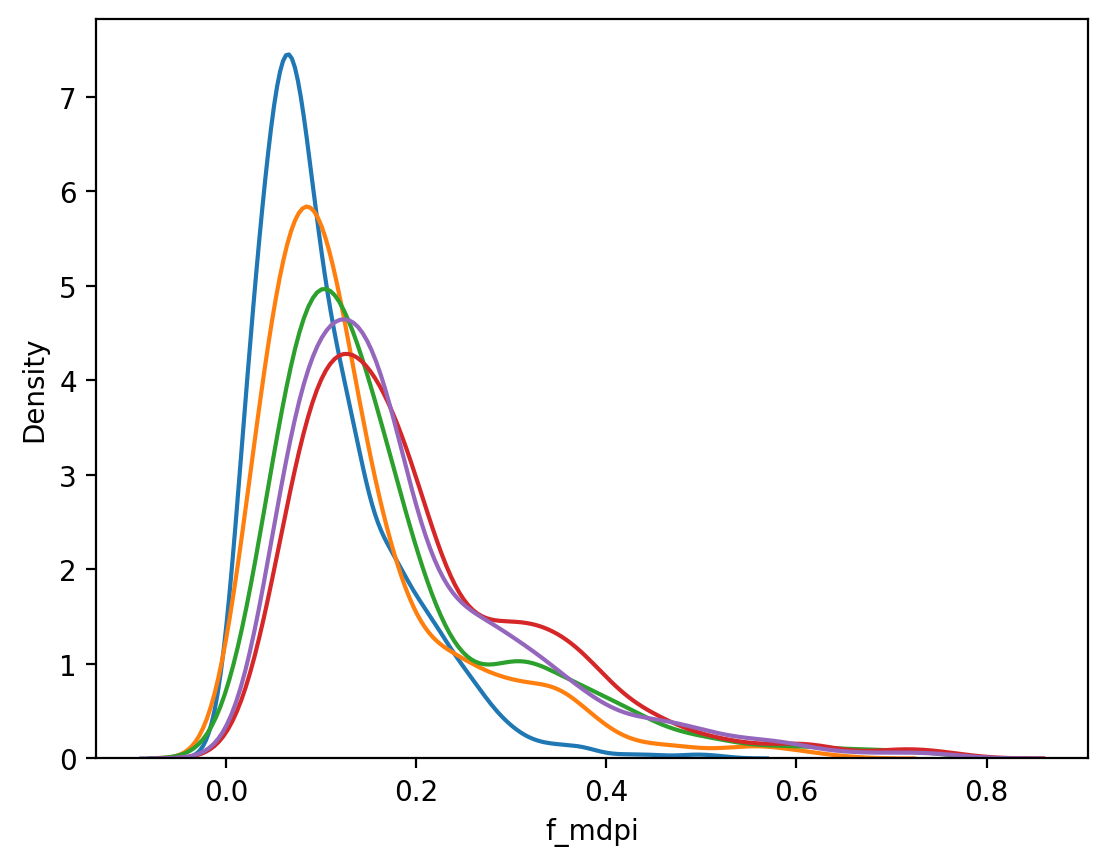

In [6]:
data2019 = data[data['year'] == '2019']
data2020 = data[data['year'] == '2020']
data2021 = data[data['year'] == '2021']
data2022 = data[data['year'] == '2022']
data2023 = data[data['year'] == '2023']
# plot kde of histograms of mdpi ratios
sns.kdeplot(data2019['f_mdpi'], label='2019')
sns.kdeplot(data2020['f_mdpi'], label='2020')
sns.kdeplot(data2021['f_mdpi'], label='2021')
sns.kdeplot(data2022['f_mdpi'], label='2022')
sns.kdeplot(data2023['f_mdpi'], label='2023')

<ErrorbarContainer object of 3 artists>

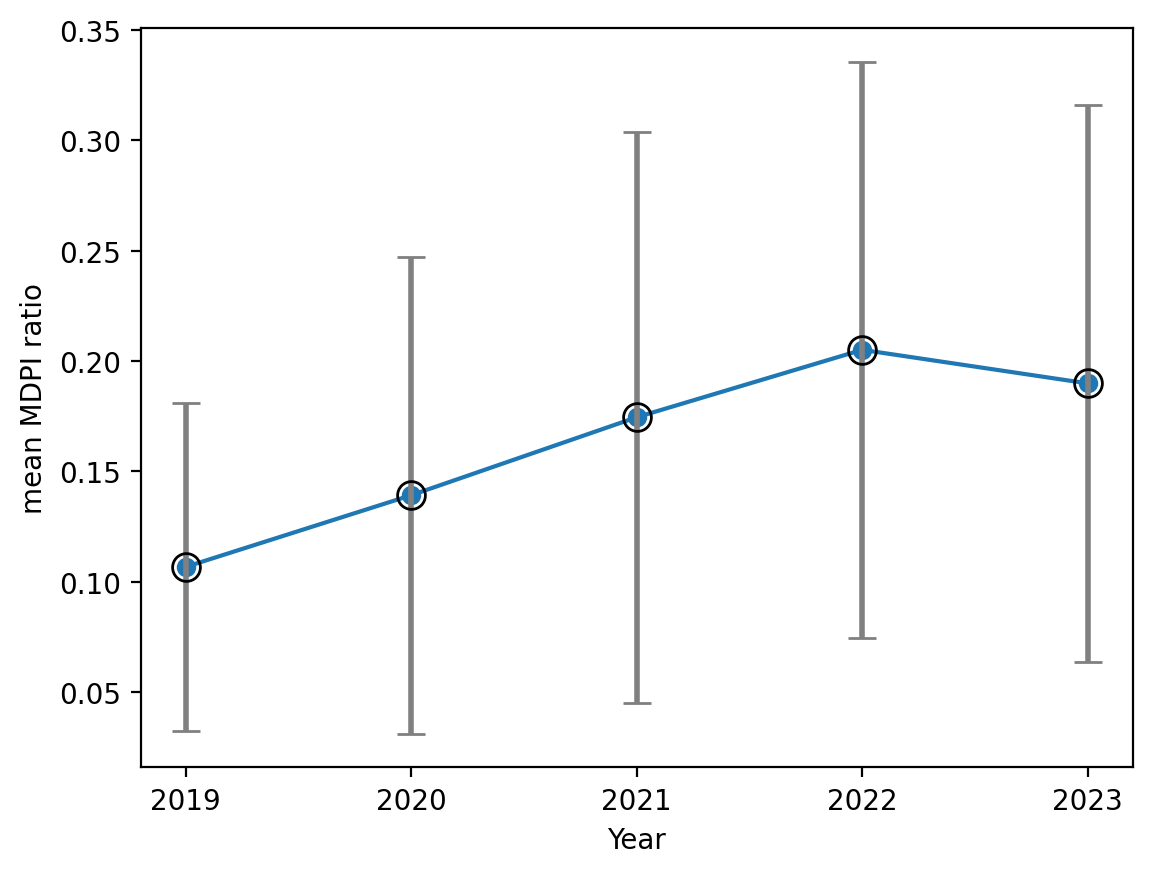

In [7]:
# plot means of mdpi ratios vs years
plt.plot(data.groupby('year')['f_mdpi'].mean(), 'o-',)
plt.xlabel('Year')
plt.ylabel('mean MDPI ratio')
# add error bars
plt.errorbar(data.groupby('year')['f_mdpi'].mean().index, data.groupby('year')['f_mdpi'].mean(), yerr=data.groupby('year')['f_mdpi'].std(), color='black', 
ecolor='gray', elinewidth=2, capsize=5,mfc='none', ms=10, fmt='o')


In [8]:
# # plot means of mdpi ratios vs years for countries, here is averaged over universities!!!!!
country_mean = data.groupby(['year', 'country'])['f_mdpi'].mean().unstack()
country_std = data.groupby(['year', 'country'])['f_mdpi'].std().unstack()

In [9]:
country_mean.head()

country,Algeria,Argentina,Australia,Austria,Belgium,Brazil,Cameroon,Canada,Chile,China,...,Taiwan,Thailand,Tunisia,Turkey,Uganda,United Arab Emirates,United Kingdom,United States,Uruguay,Viet Nam
year,,,,,,,,,,,,,,,,,,,,,
2019,0.02381,0.054562,0.076268,0.134772,0.088394,0.066126,0.061662,0.074239,0.145953,0.1169,...,0.224036,0.118783,0.075041,0.038113,0.099174,0.144305,0.065253,0.05615,0.101266,0.209668
2020,0.033557,0.05664,0.102295,0.189839,0.132201,0.088613,0.092827,0.090663,0.224513,0.097209,...,0.28547,0.154988,0.102308,0.047901,0.106904,0.175197,0.088618,0.072441,0.123214,0.184615
2021,0.074468,0.084202,0.1291,0.239281,0.173728,0.109748,0.105948,0.117597,0.26931,0.115591,...,0.359431,0.248862,0.175574,0.065711,0.151571,0.237204,0.113183,0.091281,0.148725,0.119552
2022,0.113793,0.124377,0.14632,0.234228,0.173865,0.172987,0.150391,0.136515,0.333268,0.199138,...,0.36009,0.308287,0.240037,0.093477,0.17122,0.27019,0.122164,0.103982,0.150442,0.161862
2023,0.144444,0.142247,0.132512,0.213836,0.154387,0.198549,0.121905,0.125933,0.317887,0.17774,...,0.264363,0.256196,0.246144,0.12474,0.143333,0.232212,0.112273,0.103434,0.175978,0.150552


In [10]:
# compute country means of 'n_sum' and 'n_mdpi' and compute c_mdpi from these to get average for each country from paper counts!!!!!
country_mean_nsum = data.groupby(['year', 'country'])['sum'].mean().unstack()
country_mean_nmdpi = data.groupby(['year', 'country'])['n_mdpi'].mean().unstack()

In [11]:
# compute c_mdp from these, this is the average MDPI ratio for each country from paper counts!!!!!!
country_mean_fmdpi = country_mean_nmdpi / (country_mean_nsum + country_mean_nmdpi)

In [12]:
country_mean_fmdpi.head()

country,Algeria,Argentina,Australia,Austria,Belgium,Brazil,Cameroon,Canada,Chile,China,...,Taiwan,Thailand,Tunisia,Turkey,Uganda,United Arab Emirates,United Kingdom,United States,Uruguay,Viet Nam
year,,,,,,,,,,,,,,,,,,,,,
2019,0.02381,0.05239,0.067505,0.120368,0.085745,0.062478,0.061662,0.06112,0.131122,0.105749,...,0.212352,0.111153,0.071887,0.038892,0.099174,0.144176,0.057016,0.045473,0.101266,0.220875
2020,0.033557,0.058197,0.086738,0.176411,0.129123,0.086815,0.092827,0.077475,0.1923,0.094286,...,0.266608,0.151388,0.100153,0.046725,0.106904,0.176266,0.078469,0.060953,0.123214,0.182863
2021,0.074468,0.084439,0.111613,0.223169,0.168353,0.110209,0.105948,0.102829,0.240237,0.112464,...,0.344599,0.246335,0.169544,0.064843,0.151571,0.239648,0.099522,0.079012,0.148725,0.103579
2022,0.113793,0.116175,0.126929,0.217615,0.163795,0.168876,0.150391,0.118092,0.292542,0.182525,...,0.341719,0.305832,0.233057,0.095178,0.17122,0.270679,0.106869,0.088333,0.150442,0.162162
2023,0.144444,0.136641,0.112518,0.196786,0.147125,0.195064,0.121905,0.110527,0.286457,0.158895,...,0.240082,0.251347,0.234978,0.12348,0.143333,0.234925,0.097041,0.085648,0.175978,0.146729


In [13]:
country_mean[['Croatia','Slovenia','Netherlands','United States','United Kingdom','China']]

country,Croatia,Slovenia,Netherlands,United States,United Kingdom,China
year,,,,,,
2019,0.193891,0.223427,0.075051,0.05615,0.065253,0.1169
2020,0.323064,0.348427,0.099205,0.072441,0.088618,0.097209
2021,0.480495,0.46124,0.122542,0.091281,0.113183,0.115591
2022,0.526795,0.485407,0.112858,0.103982,0.122164,0.199138
2023,0.550481,0.450051,0.094839,0.103434,0.112273,0.17774


In [14]:
country_mean_fmdpi[['Croatia','Slovenia','Netherlands','United States','United Kingdom','China']]

country,Croatia,Slovenia,Netherlands,United States,United Kingdom,China
year,,,,,,
2019,0.182371,0.197193,0.072697,0.045473,0.057016,0.105749
2020,0.321687,0.332278,0.099296,0.060953,0.078469,0.094286
2021,0.460497,0.436584,0.122586,0.079012,0.099522,0.112464
2022,0.495413,0.451367,0.113717,0.088333,0.106869,0.182525
2023,0.53268,0.416922,0.096581,0.085648,0.097041,0.158895


In [16]:
# compute differences between country_mean and country_mean_fmdpi
country_mean_diff = country_mean - country_mean_fmdpi
country_mean_diff[['Croatia','Slovenia','Netherlands','United States','United Kingdom','China']]

country,Croatia,Slovenia,Netherlands,United States,United Kingdom,China
year,,,,,,
2019,0.01152,0.026234,0.002354,0.010677,0.008237,0.011151
2020,0.001377,0.016149,-0.00009,0.011488,0.010149,0.002923
2021,0.019999,0.024655,-0.000044,0.012269,0.013662,0.003126
2022,0.031382,0.03404,-0.000859,0.015649,0.015295,0.016613
2023,0.017801,0.033128,-0.001741,0.017787,0.015232,0.018844


In [17]:
# max diff between country_mean and country_mean_fmdpi
print(country_mean_diff.abs().max().max())
# for which country and year is this max diff
country_mean_diff.abs().idxmax().idxmax(), country_mean_diff.abs().idxmax().max()
# top 10 max diffs
country_mean_diff.abs().unstack().sort_values(ascending=False).head(10)

0.04528522642971966


country         year
Czech Republic  2020    0.045285
Chile           2022    0.040726
Lithuania       2020    0.038905
Singapore       2021    0.037656
Slovakia        2022    0.037261
                2019    0.037095
South Korea     2023    0.035754
Slovakia        2021    0.035719
South Korea     2022    0.034944
Slovenia        2022     0.03404
dtype: object

In [18]:
# compute differences between country_mean and country_mean_fmdpi in %
country_mean_diff_perc = (country_mean - country_mean_fmdpi) / country_mean * 100

In [19]:
# max diff between country_mean and country_mean_diff_perc
print(country_mean_diff_perc.abs().max().max())
# top 10 max diffs in %
country_mean_diff_perc.abs().unstack().sort_values(ascending=False).head(10)

37.81437335261598


country         year
Ethiopia        2019    37.814373
Singapore       2021    26.408398
Ethiopia        2021    25.297136
Singapore       2020    20.065885
United States   2019    19.015969
Canada          2019      17.6709
Ethiopia        2023     17.55333
United States   2023    17.196087
Czech Republic  2019    16.752779
Sweden          2019    16.565123
dtype: object

<Axes: title={'center': '2022'}, xlabel='Country', ylabel='Mean MDPI ratio'>

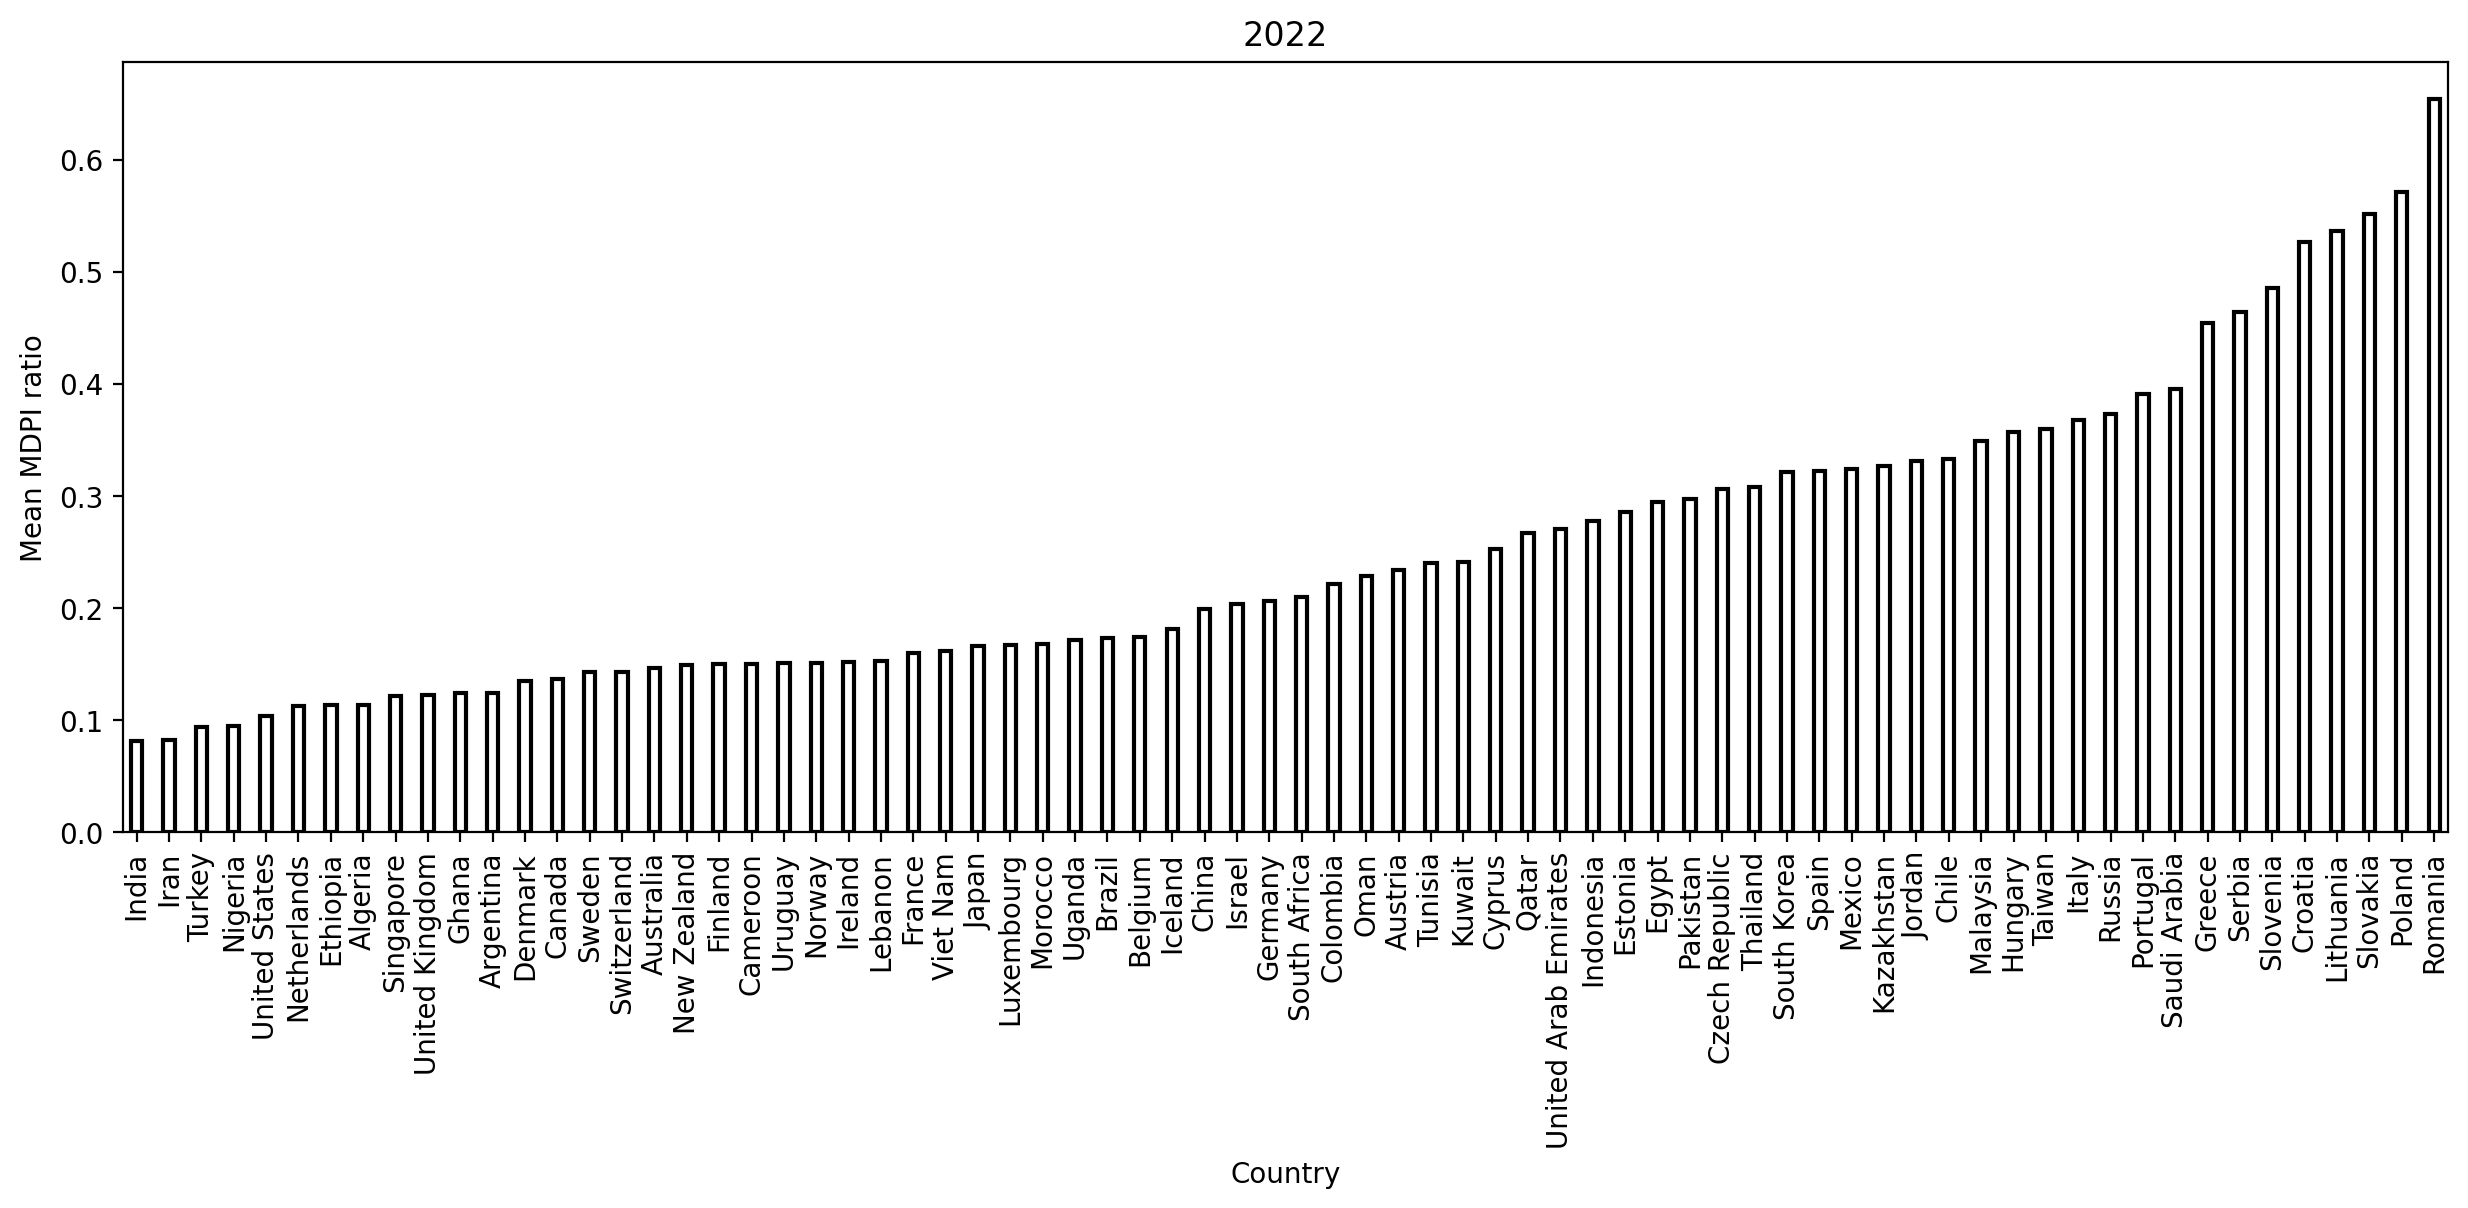

In [20]:
# plot country_mean for all countries for 2023, bar plot
country_mean.iloc[3].sort_values().plot(kind='bar', figsize=(15,5), title='2022', xlabel='Country', ylabel='Mean MDPI ratio', color='white', edgecolor='black',
width=0.35, linewidth=1.5)


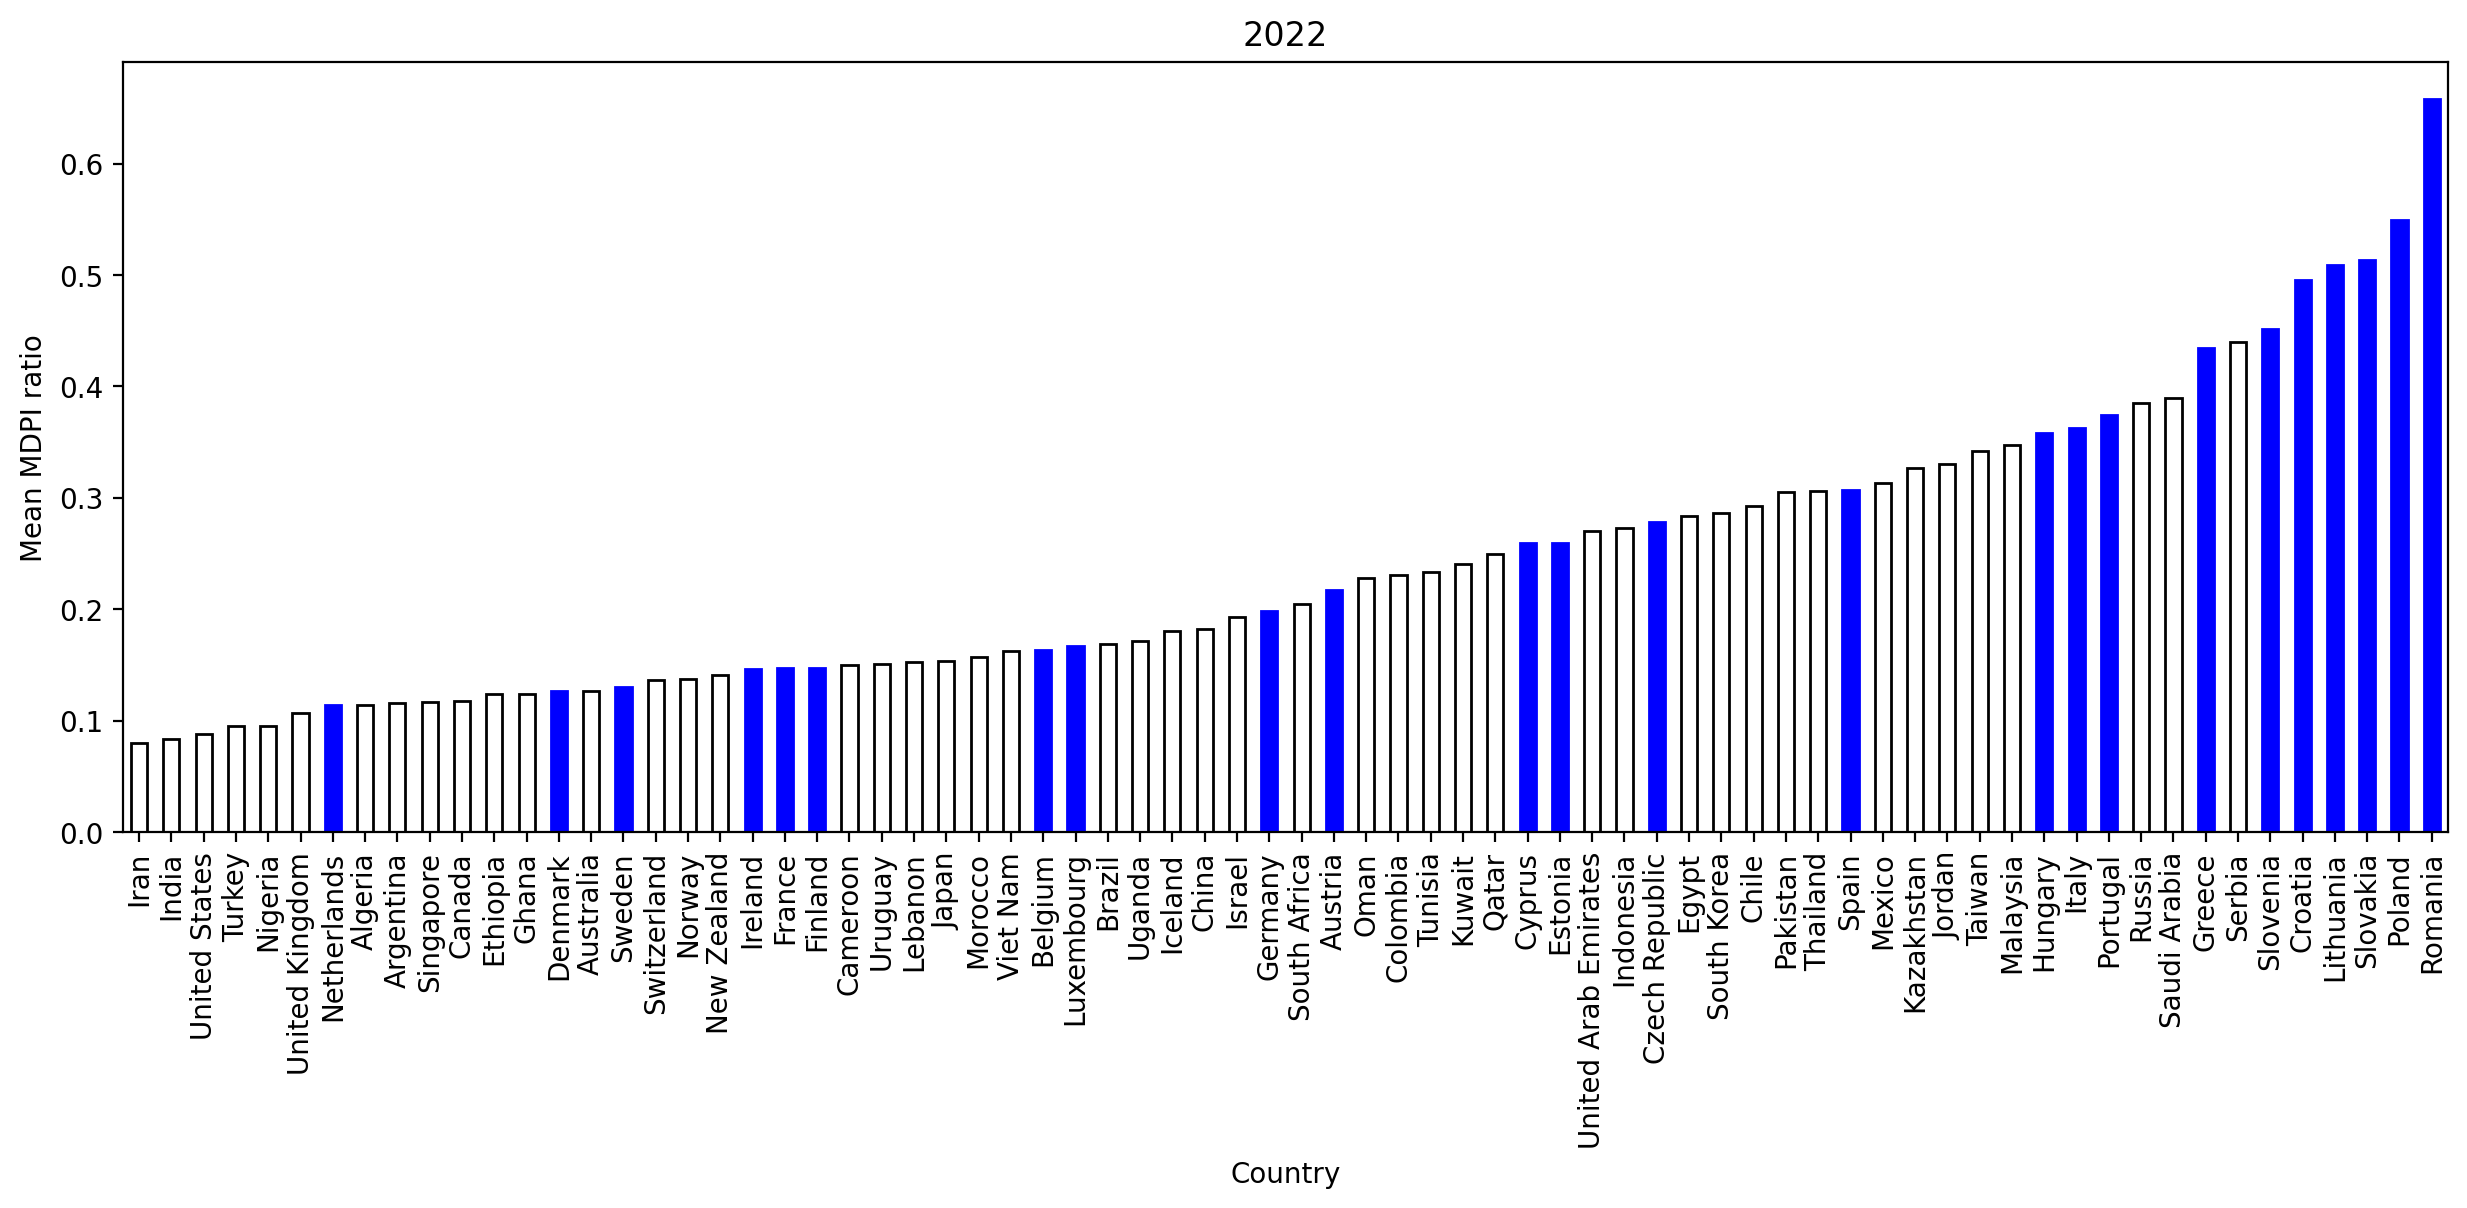

In [21]:
# plot country_mean_fmdpi.iloc[3].sort_values() as bar plot, use different color if coutry is in eu_countries
country_mean_fmdpi.iloc[3].sort_values().plot(kind='bar', figsize=(15,5), title='2022', xlabel='Country', ylabel='Mean MDPI ratio', color='white', edgecolor='black')
for i, country in enumerate(country_mean_fmdpi.iloc[3].sort_values().index):
    if country in eu_countries:
        plt.gca().get_children()[i].set_color('blue')

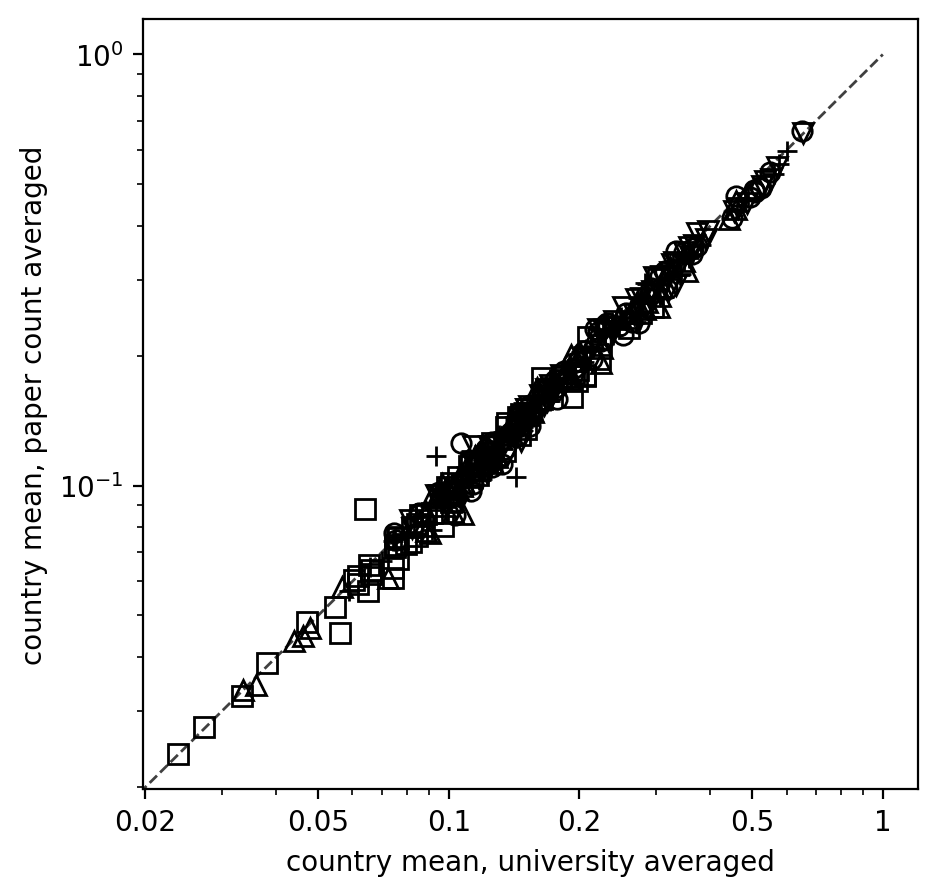

In [22]:
# plot country_mean vs country_mean_fmdpi for all countries for 2023
plt.figure(figsize=(5,5))
plt.plot(country_mean.iloc[0], country_mean_fmdpi.iloc[0], 's', color='black', markersize=7,mfc='none')
plt.plot(country_mean.iloc[1], country_mean_fmdpi.iloc[1], '^', color='black', markersize=7,mfc='none')
plt.plot(country_mean.iloc[2], country_mean_fmdpi.iloc[2], '+', color='black', markersize=7,mfc='none')
plt.plot(country_mean.iloc[3], country_mean_fmdpi.iloc[3], 'v', color='black', markersize=7,mfc='none')
plt.plot(country_mean.iloc[4], country_mean_fmdpi.iloc[4], 'o', color='black', markersize=7,mfc='none')
plt.xlabel('country mean, university averaged')
plt.ylabel('country mean, paper count averaged')
#plt.title('2023')
plt.plot([0,1],[0,1], 'k--', alpha=0.75,lw=1)
plt.loglog()
# add x labels at 0.2, 0.5, 1
plt.xticks([0.02,0.05,0.1,0.2,0.5,1], [0.02,0.05,0.1,0.2,0.5,1]);
# add label for years

In [23]:
EU = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France','Germany', 'Greece', 'Hungary', 'Ireland', 
      'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
# which EU are in country_mean countries
EU = [c for c in EU if c in country_mean.columns]

In [24]:
# compute mean of country_mean for EU countries
country_mean.loc[:,EU].mean(axis=1)

year
2019    0.159408
2020    0.238294
2021    0.306617
2022    0.320611
2023    0.298602
dtype: object

In [25]:
# compute mean of country_mean for EU countries
country_mean_fmdpi.loc[:,EU].mean(axis=1)

year
2019    0.147331
2020    0.226239
2021    0.294427
2022    0.307091
2023    0.286854
dtype: object

In [26]:
# compute mean of country_mean for non-EU countries
country_mean.loc[:,[c for c in country_mean.columns if c not in EU]].mean(axis=1)

year
2019     0.10161
2020    0.132927
2021     0.17426
2022    0.212725
2023    0.197609
dtype: object

In [27]:
EU_OLD = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden']
EU_NEW = ['Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia']

(0.09, 0.51)

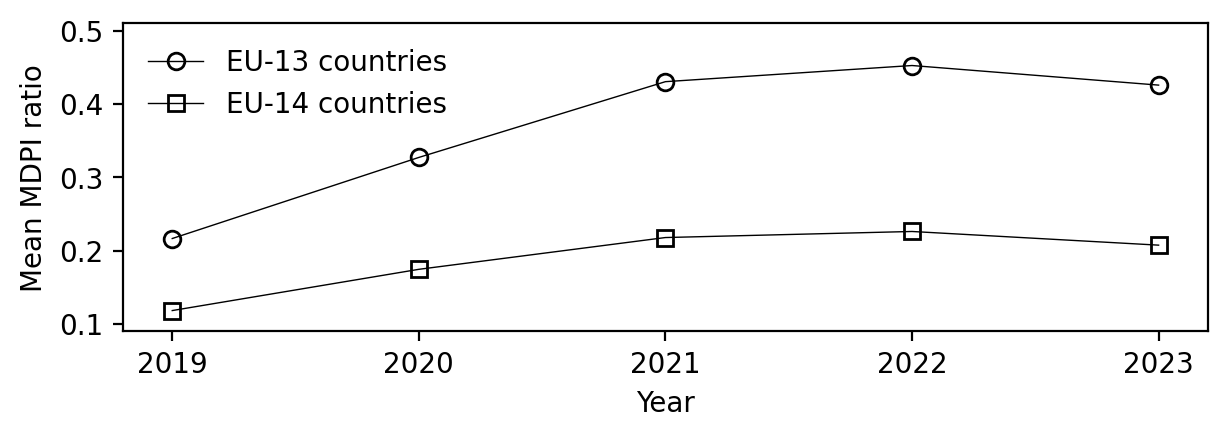

In [28]:
# compute mean of country_mean for EU_OLD countries
mean_EU_OLD = country_mean.loc[:,EU_OLD].mean(axis=1)
# compute mean of country_mean for EU_NEW countries
mean_EU_NEW = country_mean.loc[:,EU_NEW].mean(axis=1)
# plot mean_EU_OLD and mean_EU_NEW
plt.figure(figsize=(7, 2))
plt.plot(mean_EU_NEW,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(mean_EU_OLD,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel('Mean MDPI ratio')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
plt.ylim(0.09,0.51)


(0.09, 0.51)

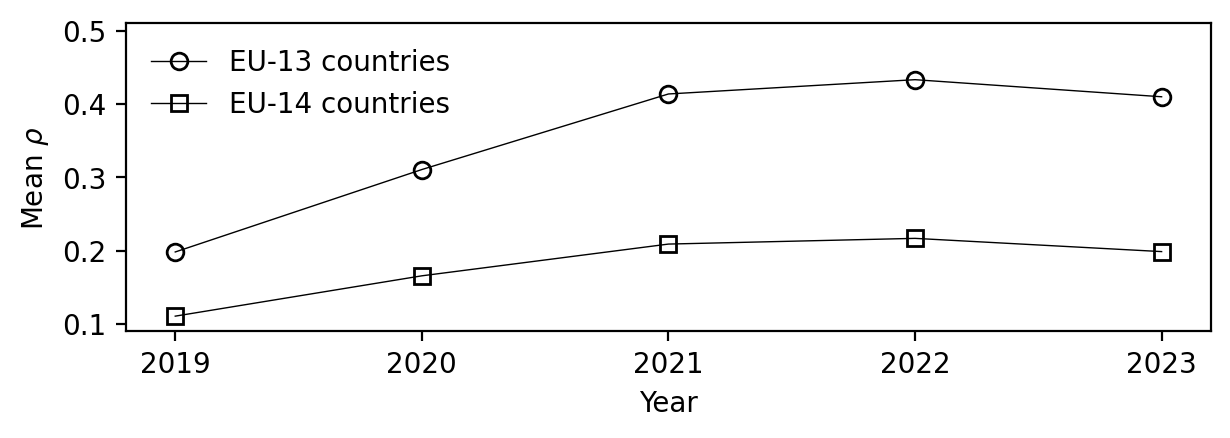

In [29]:
# compute mean of country_mean for EU_OLD countries
mean_EU_OLD = country_mean_fmdpi.loc[:,EU_OLD].mean(axis=1)
# compute mean of country_mean for EU_NEW countries
mean_EU_NEW = country_mean_fmdpi.loc[:,EU_NEW].mean(axis=1)
# plot mean_EU_OLD and mean_EU_NEW
plt.figure(figsize=(7, 2))
plt.plot(mean_EU_NEW,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(mean_EU_OLD,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel(r'Mean $\rho$')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
plt.ylim(0.09,0.51)

In [30]:
# compute sd of country_mean for EU_OLD countries
country_mean.loc[:,EU_OLD].std(axis=1)

year
2019    0.047451
2020    0.074237
2021    0.095307
2022    0.110615
2023    0.126814
dtype: object

In [31]:
# compute sd of country_mean for EU_NEW countries
country_mean.loc[:,EU_NEW].std(axis=1)

year
2019    0.065406
2020    0.111131
2021    0.140061
2022    0.140113
2023    0.151457
dtype: object

In [32]:
#mann_whitney_u_test = stats.mannwhitneyu(eu14, eu13, alternative='two-sided')
# mann_whitney_u_test on country_mean for EU_OLD and EU_NEW countries
for year in ['2019', '2020', '2021', '2022', '2023']:
    eu13 = country_mean.loc[year,EU_NEW]
    eu14 = country_mean.loc[year,EU_OLD]
    mann_whitney_u_test = stats.mannwhitneyu(eu13.to_list(), eu14.to_list(), alternative='two-sided')
    print(year, mann_whitney_u_test.pvalue)



2019 0.0021114910066705956
2020 0.0045132033540006096
2021 0.0021114910066705956
2022 0.001416864815727363
2023 0.0017324223702938223


In [33]:
#mann_whitney_u_test = stats.mannwhitneyu(eu14, eu13, alternative='two-sided')
# mann_whitney_u_test on country_mean for EU_OLD and EU_NEW countries
for year in ['2019', '2020', '2021', '2022', '2023']:
    eu13 = country_mean_fmdpi.loc[year,EU_NEW]
    eu14 = country_mean_fmdpi.loc[year,EU_OLD]
    mann_whitney_u_test = stats.mannwhitneyu(eu13.to_list(), eu14.to_list(), alternative='two-sided')
    print(year, mann_whitney_u_test.pvalue)


2019 0.0021114910066705956
2020 0.0031067106806974016
2021 0.0021114910066705956
2022 0.001416864815727363
2023 0.0021114910066705956


In [34]:
# shuffle country_mean_fmdpi
country_mean_fmdpi_shuffled = country_mean_fmdpi.loc[:,EU_NEW+EU_OLD].sample(frac=1, axis=1)
# first 13 columns are group1, last 14 columns are group2
group1 = country_mean_fmdpi_shuffled.iloc[:,:13]
group2 = country_mean_fmdpi_shuffled.iloc[:,13:]
# mann_whitney_u_test on group1 and group2
for year in ['2019', '2020', '2021', '2022', '2023']:
    eu13 = group1.loc[year]
    eu14 = group2.loc[year]
    mann_whitney_u_test = stats.mannwhitneyu(eu13.to_list(), eu14.to_list(), alternative='two-sided')
    print(year, mann_whitney_u_test.pvalue)



2019 0.5239281449175213
2020 0.8167351582026614
2021 0.8167351582026614
2022 0.8620150697772326
2023 0.8620150697772326


In [73]:
a = 2
p_values = {}
for a in range(0, 3):
    p_values[a] = {}
for a in range(0, 3):
    for year in ['2019', '2020', '2021', '2022', '2023']:
        p_values[a][year] = []

for i in range(10000):
    for a in range(0, 3):
        #shuffle EU_OLD and EU_NEW
        np.random.shuffle(EU_OLD)
        np.random.shuffle(EU_NEW)

        # switch countries
        group1 = country_mean_fmdpi.loc[:,EU_NEW[:a]+EU_OLD[a:]]
        group2 = country_mean_fmdpi.loc[:,EU_OLD[:a]+EU_NEW[a:]]

        # mann_whitney_u_test on group1 and group2
        for year in ['2019', '2020', '2021', '2022', '2023']:
            eu13 = group1.loc[year]
            eu14 = group2.loc[year]
            mann_whitney_u_test = stats.mannwhitneyu(eu13.to_list(), eu14.to_list(), alternative='two-sided')
            #print(year, mann_whitney_u_test.pvalue)
            p_values[a][year].append(mann_whitney_u_test.pvalue)



In [76]:
pvals = {}
for a in range(0, 3):
    pvals[a] = []
    for year in ['2019', '2020', '2021', '2022', '2023']:
        print(a, year, np.array(p_values[a][year]).mean())
        pvals[a].append((int(year), np.array(p_values[a][year]).mean()))

0 2019 0.002111491006670595
0 2020 0.0031067106806974007
0 2021 0.002111491006670595
0 2022 0.0014168648157273634
0 2023 0.002111491006670595
1 2019 0.018976695281715642
1 2020 0.02460737477845955
1 2021 0.018991788462592522
1 2022 0.014378743496731104
1 2023 0.0187940551655031
2 2019 0.08035316658534641
2 2020 0.09561792413139392
2 2021 0.08068771260681587
2 2022 0.06716376621366886
2 2023 0.0796938945778804


(0.0007, 0.2)

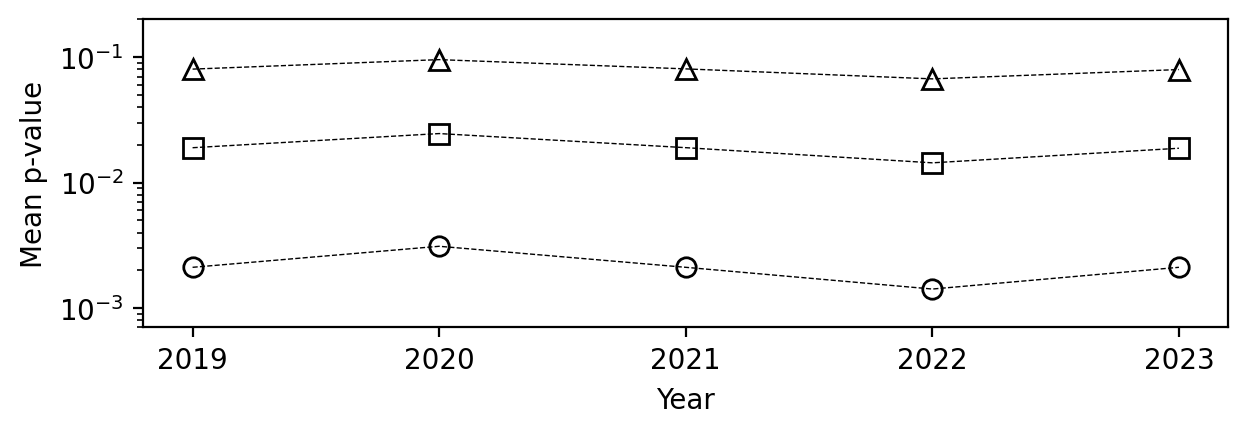

In [92]:
# plot pvals
plt.figure(figsize=(7, 2))
markers = ['o', 's', '^']
for a in range(0, 3):
    plt.plot(*zip(*pvals[a]), marker=markers[a], label=a, markersize=7,mfc='none',color='black',lw=0.5, ls='--',)
# use different markers for different a
#plt.legend()
plt.xlabel('Year')
plt.ylabel('Mean p-value')
plt.yscale('log')
# x ticks at 2020, 2021, 2022, 2023
plt.xticks([2019, 2020, 2021, 2022, 2023]);
plt.ylim(0.7*1e-3,2e-1)


In [603]:
# Create a Gaussian Mixture model for universities
gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
dt = data2022['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

# Print estimated parameters
print("Weights:", weights)
print("Means:", means)
print("Standard Deviations:", stds)

# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


Weights: [0.63834581 0.36165419]
Means: [0.13416033 0.33037041]
Standard Deviations: [0.05216914 0.13300692]


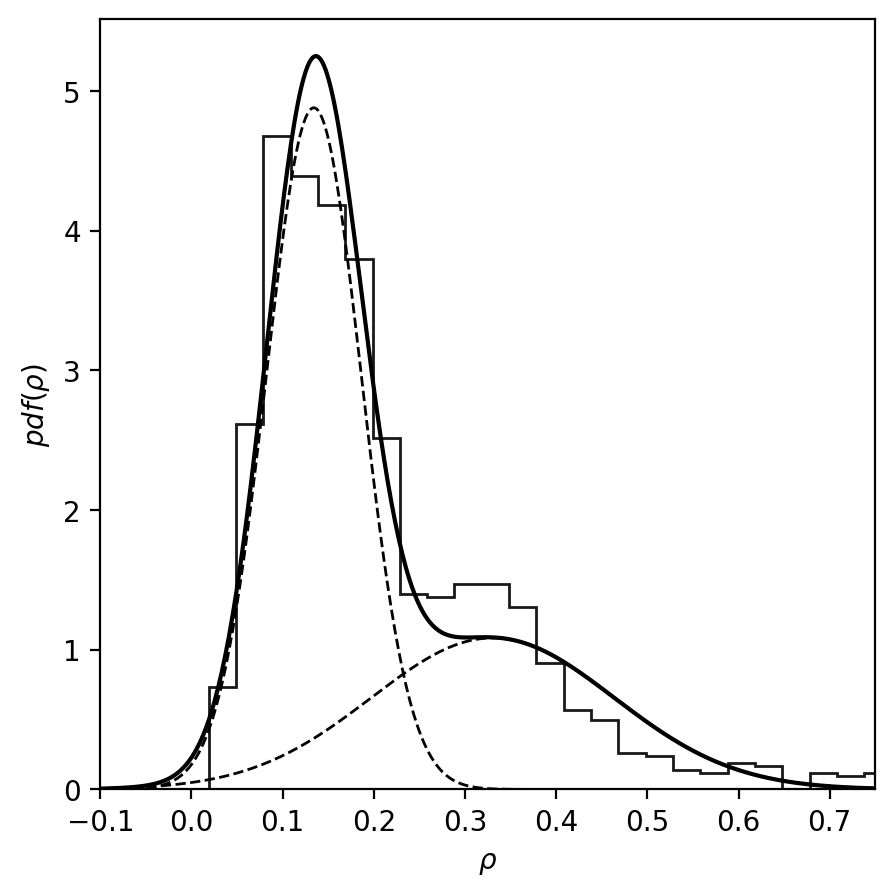

In [604]:
plt.figure(figsize=(5, 5))
plt.hist(dt, bins=25, density=True, alpha=0.9, color='black',histtype='step')
plt.plot(x, pdf, '-k', color='black', lw=1.0)
plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k')
#plt.title('Gaussian Mixture Model')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$pdf(\rho)$')
plt.xlim(-.1, .75)
# log y scale
#plt.yscale('log')
#plt.ylim(1e-2, 20)
# plot size
plt.show()

In [605]:
# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(dt.reshape(-1, 1))

# Predict the posterior probabilities
posterior_probs = gmm.predict_proba(dt.reshape(-1, 1))


# Assign each indicator to the component with the highest posterior probability
clusters = np.argmax(posterior_probs, axis=1)


# Separate the original indicators into two groups based on the assigned clusters
group1 = dt[clusters == 0]
group2 = dt[clusters == 1]


In [480]:
# unique values in clusters
np.unique(clusters)

array([0, 1])

In [481]:
#country_mean.iloc[0].index[clusters == 0]
c1 = data2022['country'][clusters == 1].unique()
c2 = data2022['country'][clusters == 0].unique()
#c1 = country_mean.iloc[4].index[clusters == 1]
#c2 = country_mean.iloc[4].index[clusters == 0]

In [486]:
# which c1 are in countries
cluster1 = [c for c in c1 if c in countries]

In [487]:
# which countries are in both c1 and c2
both_clusters = [c for c in c1 if c in c2 and c in countries]


In [488]:
cluster2 = [c for c in c2 if c in countries]

In [490]:
# countries in cluster 1 but not in both clusters
[c for c in cluster1 if c not in both_clusters]

['Poland',
 'Greece',
 'Romania',
 'Hungary',
 'Slovakia',
 'Lithuania',
 'Portugal',
 'Slovenia',
 'Croatia']

In [491]:
[c for c in cluster2 if c not in both_clusters]

['Denmark', 'Finland', 'Netherlands', 'Ireland', 'Luxembourg']

In [600]:
both_clusters

['Italy',
 'Czech Republic',
 'Spain',
 'Germany',
 'France',
 'Austria',
 'Sweden',
 'Cyprus',
 'Estonia',
 'Belgium']

In [607]:
x[np.where(pdf == pdf[(x>means[0]) & (x<means[1])].min())[0][0]]

0.3013013013013013

In [614]:
# show countries in data2022 for which f_mdpi is lower than 0.3
low_fmdpi = data2022[data2022['f_mdpi'] < 0.3]['country'].unique()
high_fmdpi = data2022[data2022['f_mdpi'] > 0.3]['country'].unique()
low_cluster = [c for c in low_fmdpi if c in eu_countries]
high_cluster = [c for c in high_fmdpi if c in eu_countries]

In [617]:
# countries in low_cluster but not in high_cluster
[c for c in high_cluster if c in low_cluster]

['Poland',
 'Hungary',
 'Italy',
 'Germany',
 'Czech Republic',
 'Spain',
 'Estonia',
 'Austria']

In [620]:
high_cluster

['Poland',
 'Greece',
 'Romania',
 'Hungary',
 'Italy',
 'Germany',
 'Slovakia',
 'Czech Republic',
 'Lithuania',
 'Spain',
 'Estonia',
 'Portugal',
 'Slovenia',
 'Croatia',
 'Austria']

In [621]:
low_cluster

['Denmark',
 'Finland',
 'France',
 'Germany',
 'Italy',
 'Czech Republic',
 'Spain',
 'Sweden',
 'Netherlands',
 'Ireland',
 'Cyprus',
 'Hungary',
 'Belgium',
 'Austria',
 'Luxembourg',
 'Estonia',
 'Poland']

In [471]:
# diff means from gmm model
diff_means = []

gmm = GaussianMixture(n_components=2, random_state=0)
dt = data2019['f_mdpi'].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = data2020['f_mdpi'].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = data2021['f_mdpi'].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = data2022['f_mdpi'].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = data2023['f_mdpi'].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])




In [90]:
diff_means

[0.11597967603640054,
 0.18645721965534234,
 0.21960455764977005,
 0.19621007666683898,
 0.1993678026456447]

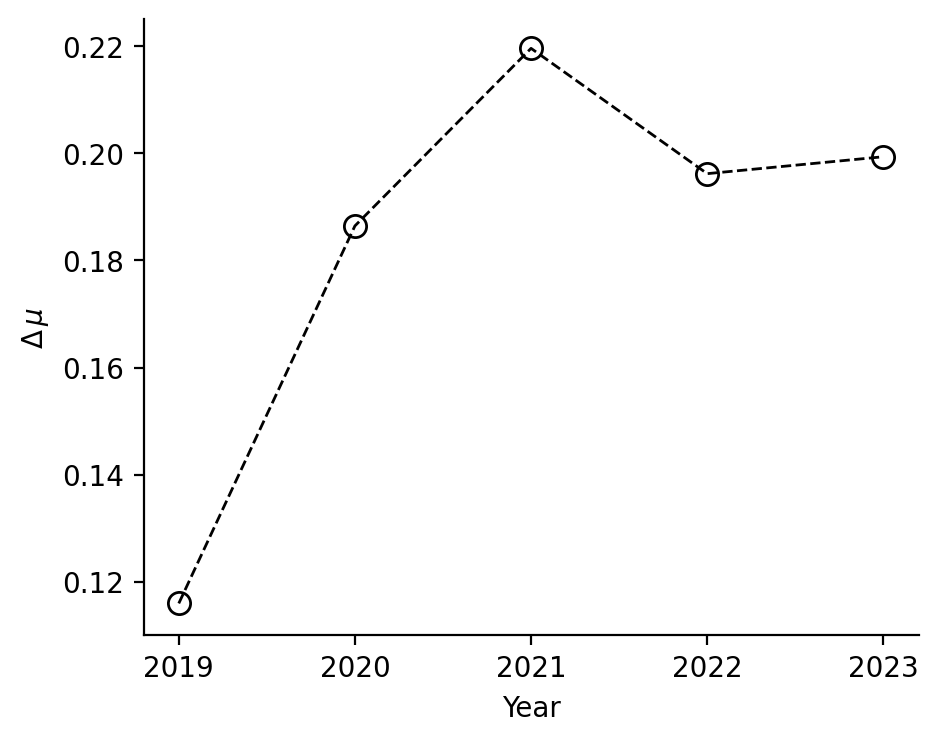

In [118]:
# plot diff_means
plt.figure(figsize=(5, 4))
plt.plot([2019, 2020, 2021, 2022, 2023], diff_means, color='black', marker='.',markersize=16, mfc='none', ls='--', lw=1)
plt.xlabel('Year')
plt.ylabel(r'$\Delta\, \mu$')
# plot x labels at 2020, 2021, 2022, 2023
plt.ylim(0.11, 0.225)
plt.xticks([2019, 2020, 2021, 2022, 2023], [2019, 2020, 2021, 2022, 2023]);
# only left and bottom axes
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


In [664]:
# Create a Gaussian Mixture model for countries
gmm = GaussianMixture(n_components=2, random_state=0)

dt = country_mean_fmdpi.iloc[3].values.reshape(-1, 1)
#dt = data2022['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

# Print estimated parameters
print("Weights:", weights)
print("Means:", means)
print("Standard Deviations:", stds)

# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

Weights: [0.57624559 0.42375441]
Means: [0.31596155 0.13658109]
Standard Deviations: [0.11824159 0.02953391]


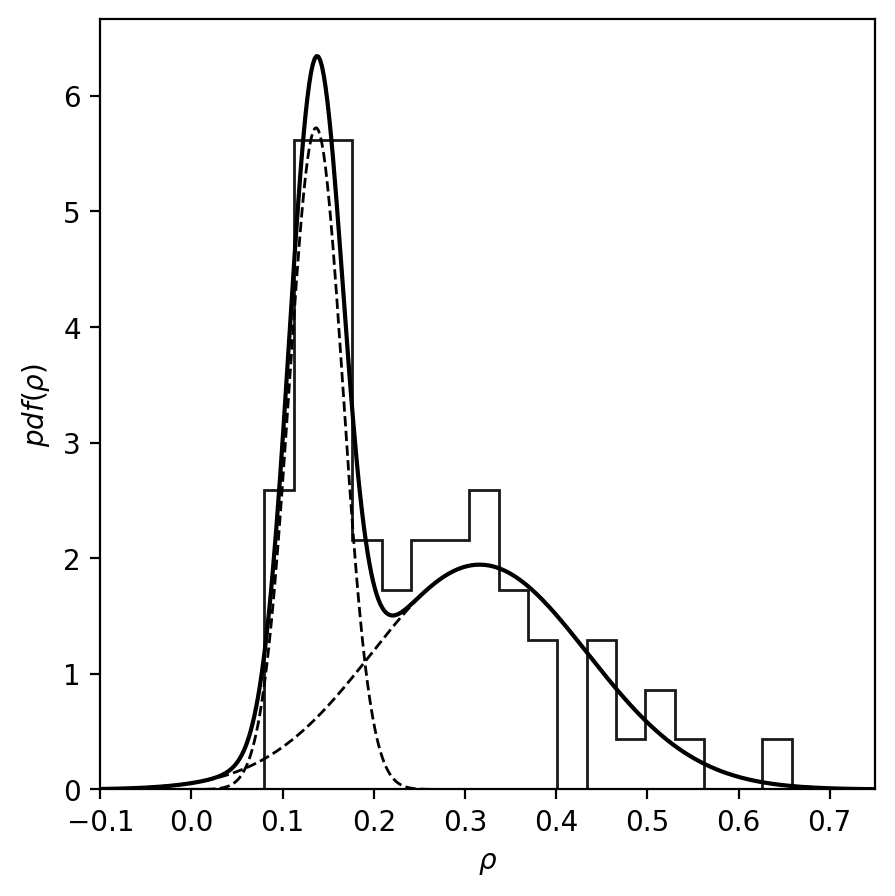

In [665]:
plt.figure(figsize=(5, 5))
plt.hist(dt, bins=18, density=True, alpha=0.9, color='black',histtype='step')
plt.plot(x, pdf, '-k', color='black', lw=1.0)
plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k')
#plt.title('Gaussian Mixture Model')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$pdf(\rho)$')
plt.xlim(-.1, .75)
# log y scale
#plt.yscale('log')
#plt.ylim(1e-2, 20)
# plot size
plt.show()

In [666]:
# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(dt.reshape(-1, 1))

# Predict the posterior probabilities
posterior_probs = gmm.predict_proba(dt.reshape(-1, 1))


# Assign each indicator to the component with the highest posterior probability
clusters = np.argmax(posterior_probs, axis=1)


# Separate the original indicators into two groups based on the assigned clusters
group1 = dt[clusters == 0]
group2 = dt[clusters == 1]

In [593]:
x[np.where(pdf == pdf[(x>means[1]) & (x<means[0])].min())[0][0]]

0.22122122122122123

In [502]:
#country_mean.iloc[0].index[clusters == 0]
#c1 = data2022['country'][clusters == 1].unique()
#c2 = data2022['country'][clusters == 0].unique()
c1 = country_mean_fmdpi.iloc[3].index[clusters == 1]
c2 = country_mean_fmdpi.iloc[3].index[clusters == 0]

In [503]:
[c for c in c1 if c in countries]

['Belgium',
 'Denmark',
 'Finland',
 'France',
 'Ireland',
 'Luxembourg',
 'Netherlands',
 'Sweden']

In [504]:
[c for c in c1 if c in c2 and c in countries]

[]

In [505]:
[c for c in c2 if c in countries]

['Austria',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Estonia',
 'Germany',
 'Greece',
 'Hungary',
 'Italy',
 'Lithuania',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain']

In [687]:
# from country_mean_fmdpi, get countries that are in countries, sort
ctrs = country_mean_fmdpi.iloc[3].sort_values()
ctrs[ctrs.index.isin(countries)]

country
Netherlands       0.113717
Denmark           0.126465
Sweden            0.130302
Ireland           0.146771
France            0.147408
Finland            0.14747
Belgium           0.163795
Luxembourg         0.16726
Germany             0.1984
Austria           0.217615
Cyprus            0.259318
Estonia           0.259837
Czech Republic    0.278728
Spain             0.307246
Hungary             0.3582
Italy             0.362438
Portugal           0.37397
Greece            0.434173
Slovenia          0.451367
Croatia           0.495413
Lithuania         0.508653
Slovakia          0.513981
Poland            0.549331
Romania           0.658331
Name: 2022, dtype: object

In [688]:
# add column country_std to ctrs
ctrs = pd.concat([ctrs, country_std.iloc[3]], axis=1)

In [689]:
# rename first column to mean, second column to std
ctrs.columns = ['mean', 'std']

ctrs[ctrs.index.isin(countries)]
# non nan values in std column
#ctrs = ctrs[ctrs['std'].notna()]
ctrs[ctrs.index.isin(eu_countries)].shape


(24, 2)

Text(-1.7, 0.136581093210771, '$\\mu_2$')

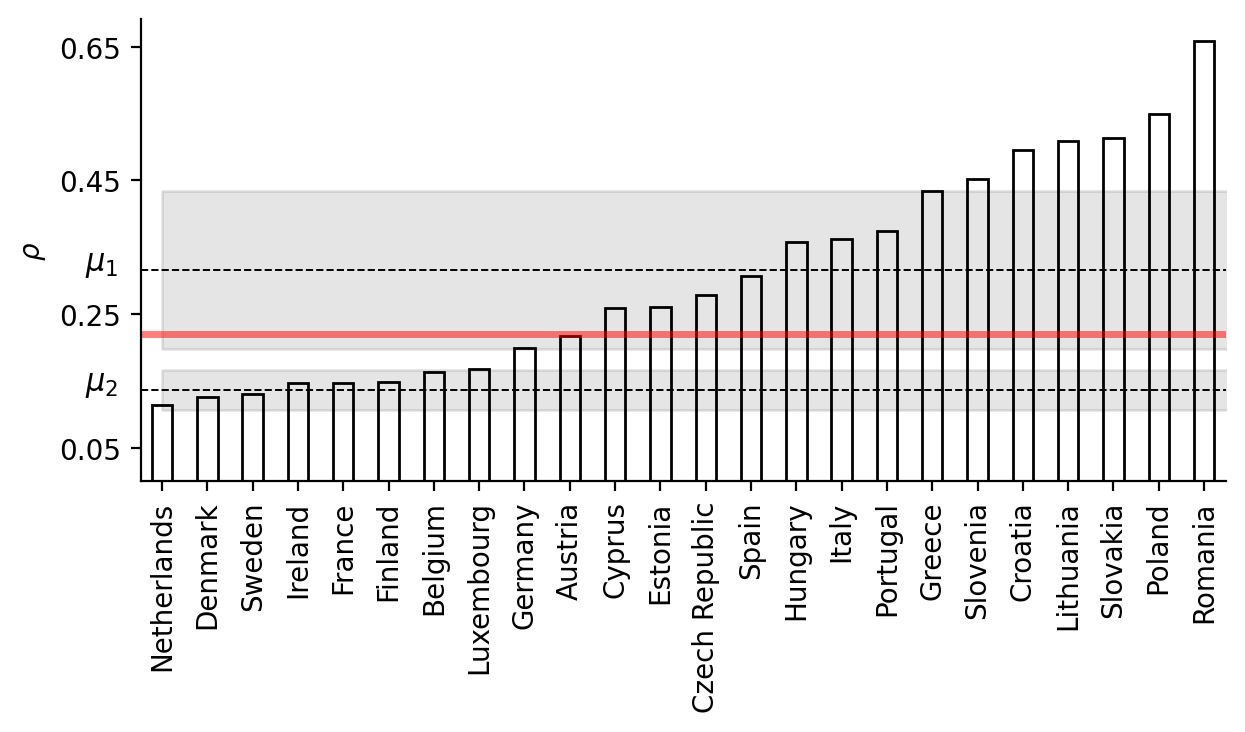

In [709]:
# bar plot of country_mean_fmdpi for 2022 for countries
plt.axhline(y=0.22, color='red', linestyle='-', lw=2.5, alpha=0.5)

ctrs['mean'][ctrs.index.isin(eu_countries)].plot(kind='bar', figsize=(7,3), ylabel=r'$\rho$', color='white', edgecolor='black',
width=0.45, linewidth=1., xlabel='')
# only left and bottom axes
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# add horizontal line at 0.23
# add horizontal line at means[0] and means[1]
plt.axhline(y=means[0], color='black', linestyle='--', lw=.7,)
plt.axhline(y=means[1], color='black', linestyle='--', lw=.7)
# add shaded areas around means[0] and means[1] with stds[0] and stds[1]
plt.fill_between([0, 26], means[0]-stds[0], means[0]+stds[0], color='black', alpha=0.1)
plt.fill_between([0, 26], means[1]-stds[1], means[1]+stds[1], color='black', alpha=0.1)
# add error bars for std
#plt.errorbar(range(23), ctrs['mean'][ctrs.index.isin(eu_countries)], yerr=ctrs['std'][ctrs.index.isin(eu_countries)], color='black',
#ecolor='gray', elinewidth=1, capsize=2, fmt='none')
# y ticks at 0.1, 0.2, 0.3, 0.5
plt.yticks([0.05, 0.25, 0.45,0.65], [0.05, 0.25, 0.45,0.65]);
# y axis label $\mu_1$ at means[0], $\mu_2$ at means[1]
plt.text(-1.7, means[0]+0.0, r'$\mu_1$', fontsize=11)
plt.text(-1.7, means[1]+0.0, r'$\mu_2$', fontsize=11)


In [631]:
means, (means[1]+means[0])/2, stds

(array([0.31596155, 0.13658109]),
 0.22627132236854056,
 array([0.11824159, 0.02953391]))

In [638]:
# name column of ctrs 'f_mdpi'
ctrs.name = 'f_mdpi'
ctrs['f_mdpi'].mean()

KeyError: 'f_mdpi'

In [634]:
country_std.loc['2022']['country'].sort_values()

country
Algeria                      NaN
Argentina               0.024269
Australia               0.048799
Austria                 0.050191
Belgium                 0.032760
                          ...   
United Arab Emirates    0.049191
United Kingdom          0.039792
United States           0.038815
Uruguay                      NaN
Viet Nam                0.009900
Name: 2022, Length: 72, dtype: float64

In [474]:
# diff means from gmm model
diff_means = []

gmm = GaussianMixture(n_components=2, random_state=0)
dt = country_mean_fmdpi.iloc[0].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = country_mean_fmdpi.iloc[1].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = country_mean_fmdpi.iloc[2].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = country_mean_fmdpi.iloc[3].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

gmm = GaussianMixture(n_components=2, random_state=0)
dt = country_mean_fmdpi.iloc[4].values.reshape(-1, 1)
gmm.fit(dt)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
diff_means.append(means[1]-means[0])

In [475]:
np.abs(diff_means)

array([0.08681463, 0.13967622, 0.17386544, 0.17938046, 0.23208917])

(0.09, 0.51)

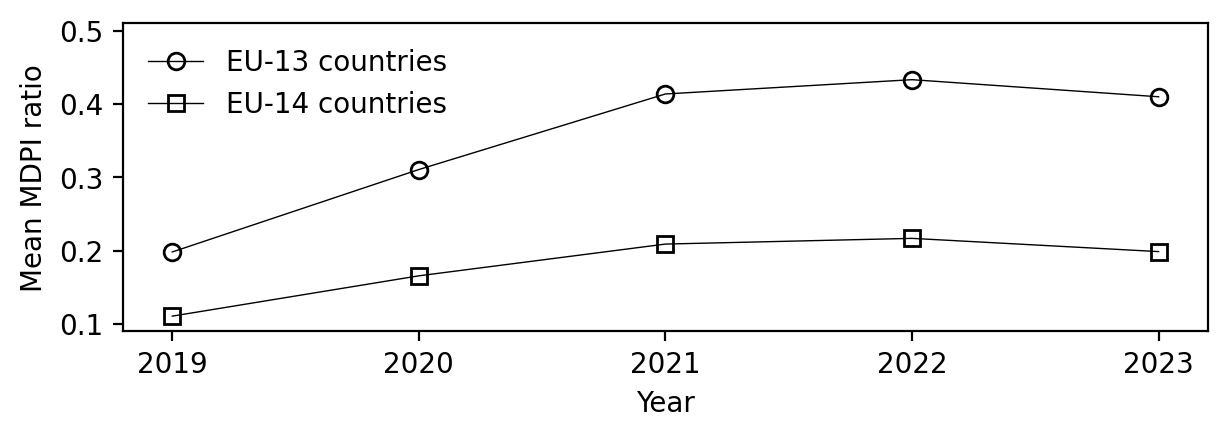

In [601]:
# compute mean of country_mean for EU_OLD countries
mean_EU_OLD = country_mean_fmdpi.loc[:,EU_OLD].mean(axis=1)
# compute mean of country_mean for EU_NEW countries
mean_EU_NEW = country_mean_fmdpi.loc[:,EU_NEW].mean(axis=1)
# plot mean_EU_OLD and mean_EU_NEW
plt.figure(figsize=(7, 2))
plt.plot(mean_EU_NEW,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(mean_EU_OLD,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel('Mean MDPI ratio')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
plt.ylim(0.09,0.51)

In [602]:
#mann_whitney_u_test = stats.mannwhitneyu(eu14, eu13, alternative='two-sided')
# mann_whitney_u_test on country_mean for EU_OLD and EU_NEW countries
for year in ['2019', '2020', '2021', '2022', '2023']:
    eu13 = country_mean.loc[year,EU_NEW]
    eu14 = country_mean.loc[year,EU_OLD]
    mann_whitney_u_test = stats.mannwhitneyu(eu13.to_list(), eu14.to_list(), alternative='two-sided')
    print(year, mann_whitney_u_test.pvalue)


2019 0.0021114910066705956
2020 0.0045132033540006096
2021 0.0021114910066705956
2022 0.001416864815727363
2023 0.0017324223702938223


In [177]:
df = pd.read_excel('../CWTS Leiden Ranking Open Edition 2023 - Results.xlsx', sheet_name='Results')
df['Period'] = df['Period'].str.replace('\u2013', '\u002d')

In [178]:
# from df select rows with 'All sciences' in 'Field', '1' in 'Frac_counting', '2018-2021' in 'Period'
df['Period'] = df['Period'].str.replace('\u2013', '\u002d')
#df_sel = df[(df['Field'] == 'All sciences') & (df['Frac_counting'] == '1') & (df['Period'] == '2018-2021')]
df_sel = df[(df['Field'] == 'All sciences')]
df_sel = df_sel[(df_sel['Frac_counting'] == 1)]
df_sel = df_sel[(df_sel['Period'] == '2018-2021')]



In [179]:
# combine data and df_sel on 'ROR_ID' column
data = data2023.merge(df_sel, left_on='ror id', right_on='ROR ID', how='left')
# order data by 'impact_P'  
data = data.sort_values(by='impact_P', ascending=False)
# add rank column to data
data['rank'] = range(1, len(data)+1)


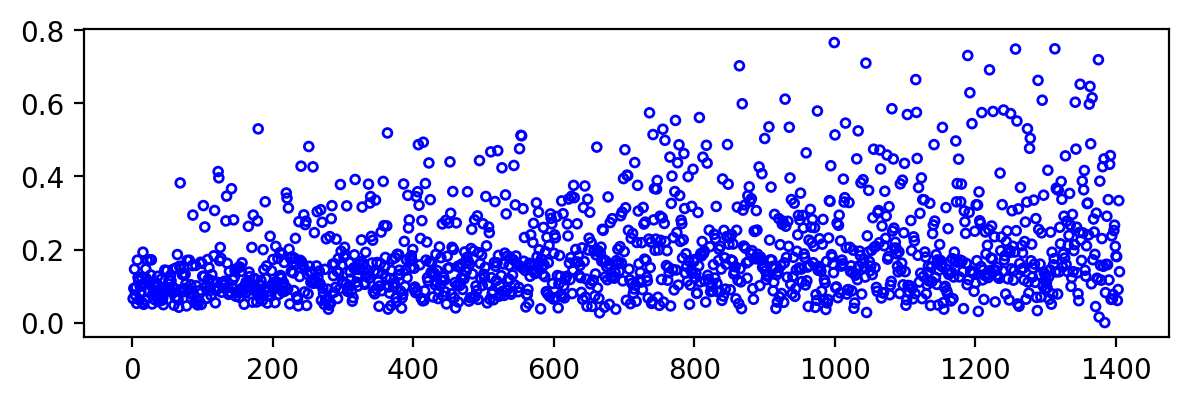

In [157]:
fig, ax = plt.subplots()
yy = data['f_mdpi']
xx = data['rank']
ax.scatter(xx, yy, marker='o', s=10, facecolors='none', edgecolors='b')

plt.gcf().set_size_inches(7, 2)
#ax.set_xlim(0.65, 1.01)
#ax.set_ylim(0.3, 1.1)

In [158]:
# compute correlation and test for significance
x1 = xx.to_list()
y1 = yy.to_list()
corr = stats.pearsonr(x1,y1)[0]
p_val = stats.pearsonr(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)
corr = stats.spearmanr(x1,y1)[0]
p_val = stats.spearmanr(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)
corr = stats.kendalltau(x1,y1)[0]
p_val = stats.kendalltau(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)




Correlation: 0.27840030271805244
P-value: 2.0033169192077453e-26
Correlation: 0.27969890532217034
P-value: 1.1489955306964357e-26
Correlation: 0.18997571745292546
P-value: 1.436225721895697e-26


In [159]:
x = np.array(data['rank'].values)
y = np.array(data['f_mdpi'].values)

# find minimum x value greater than 0


# Define bins for a12 data
nbins = 50
bins = np.arange(0, np.max(x), nbins)  # 0-10, 10-20, ..., 90-100
# make log bins
#bins = np.logspace(0, np.log10(np.max(x)), nbins)


# Digitize the a12 data into bins
x_binned = np.digitize(x, bins)

# Calculate the mean of c10 in each bin
y_means = [y[x_binned == i].mean() for i in range(1, len(bins))]

# Mid-point of bins for plotting purposes
bin_midpoints = (bins[:-1] + bins[1:]) / 2

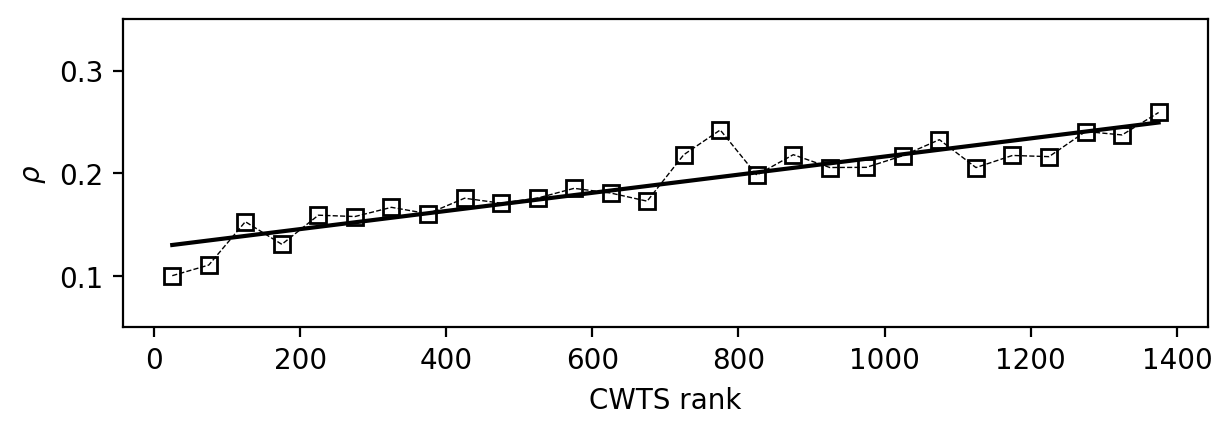

In [162]:
# Create the plot
plt.figure(figsize=(7, 2))
#plt.plot(x, y, alpha=0.2, label="Original Data", marker='.', ms=5, ls='', color='gray', mfc='none')  # Original data
plt.plot(bin_midpoints, y_means, marker='s',color="black", label="Binned Means", ms=6, ls='--', mfc='none',lw=0.5)  # Binned data
plt.xlabel('CWTS rank')
plt.ylabel(r'$\rho$')
# add linear fit line
plt.plot(np.unique(bin_midpoints), np.poly1d(np.polyfit(bin_midpoints, y_means, 1))(np.unique(bin_midpoints)), color='black', lw=1.5)
#plt.legend()
#plt.grid(True)
#plt.xlim(0, 1000)
plt.ylim(0.05, .35)
# log scale
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [163]:
x1 = bin_midpoints
y1 = y_means
corr = stats.pearsonr(x1,y1)[0]
p_val = stats.pearsonr(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)

Correlation: 0.9162812659464441
P-value: 7.834222337838606e-12


In [165]:
# get countries and rank from df data
cwts_country = data['country']
rank = data['rank']




In [167]:
cwts_country.head(), rank.head()

(290     United States
 722             China
 1395            China
 1244           Canada
 750             China
 Name: country, dtype: object,
 290     1
 722     2
 1395    3
 1244    4
 750     5
 Name: rank, dtype: int64)

In [383]:
# get average rank for each country
country_rank = data.groupby('country')['rank'].min()
country_rank = country_rank.sort_values()
ctr_rank = pd.concat([country_mean_fmdpi.iloc[4], country_rank], axis=1)
ctr_rank = ctr_rank.sort_values(by='rank')
ctr_rank['ranked'] = range(1, len(ctr_rank)+1)

In [392]:
x = np.array(ctr_rank['ranked'].values)
y = np.array(ctr_rank['2023'].values)

# find minimum x value greater than 0


# Define bins for a12 data
nbins = 4
bins = np.arange(0, np.max(x), nbins)  # 0-10, 10-20, ..., 90-100
# make log bins
#bins = np.logspace(0, np.log10(np.max(x)), nbins)


# Digitize the a12 data into bins
x_binned = np.digitize(x, bins)

# Calculate the mean of c10 in each bin
y_means = [y[x_binned == i].mean() for i in range(1, len(bins))]

# Mid-point of bins for plotting purposes
bin_midpoints = (bins[:-1] + bins[1:]) / 2

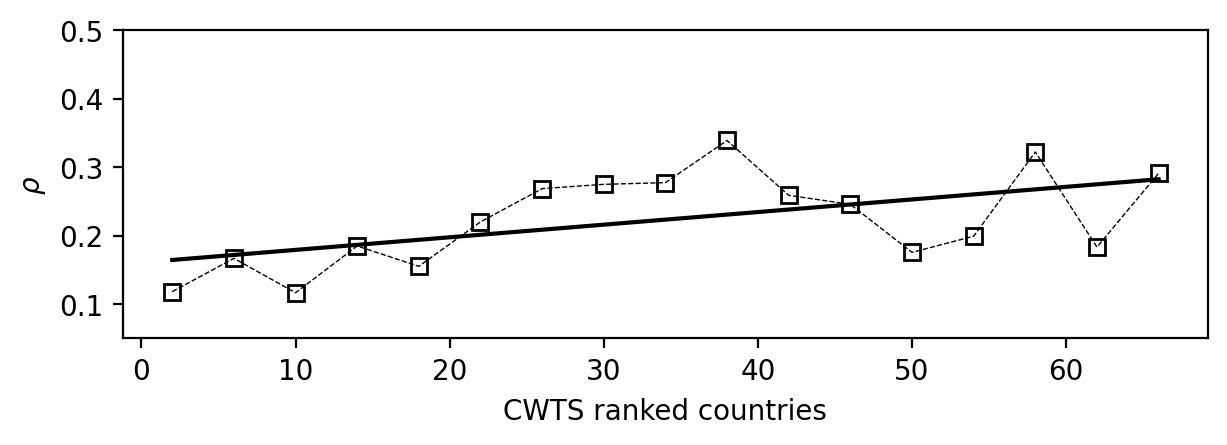

In [393]:
# Create the plot
plt.figure(figsize=(7, 2))
#plt.plot(x, y, alpha=0.2, label="Original Data", marker='.', ms=5, ls='', color='gray', mfc='none')  # Original data
plt.plot(bin_midpoints, y_means, marker='s',color="black", label="Binned Means", ms=6, ls='--', mfc='none',lw=0.5)  # Binned data
plt.xlabel('CWTS ranked countries')
plt.ylabel(r'$\rho$')
# add linear fit line
plt.plot(np.unique(bin_midpoints), np.poly1d(np.polyfit(bin_midpoints, y_means, 1))(np.unique(bin_midpoints)), color='black', lw=1.5)
#plt.legend()
#plt.grid(True)
#plt.xlim(0, 1000)
plt.ylim(0.05, .5)
# log scale
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [394]:
# corr between bin_midpoints and y_means
x1 = bin_midpoints
y1 = y_means
corr = stats.pearsonr(x1,y1)[0]
p_val = stats.pearsonr(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)
# corr between bin_midpoints and y_means
x1 = bin_midpoints
y1 = y_means
corr = stats.spearmanr(x1,y1)[0]
p_val = stats.spearmanr(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)
# corr between bin_midpoints and y_means
x1 = bin_midpoints
y1 = y_means
corr = stats.kendalltau(x1,y1)[0]
p_val = stats.kendalltau(x1,y1)[1]
print('Correlation:', corr)
print('P-value:', p_val)



Correlation: 0.549416525832418
P-value: 0.022344210548132418
Correlation: 0.5539215686274511
P-value: 0.02104982486706772
Correlation: 0.39705882352941174
P-value: 0.027329794647271987


In [ ]:
###### comparison with COARA list ######

In [395]:
ROR_API_ENDPOINT = "https://api.ror.org/organizations"
input_id = 'University of Maribor'
search_term = '"' + input_id + '"'
params = {'query': search_term}
response = requests.get(ROR_API_ENDPOINT + '?' + urllib.parse.urlencode(params)).json()

In [396]:
if response['number_of_results'] == 0:
    ror_id = ''
elif response['number_of_results'] == 1:
    ror_id = response['items'][0]['id']
else:
    ror_id = ''
    for items in response:
        ror_id = ror_id + ", " + response['items'][0]['id']
print("Found match: " + ror_id)

Found match: https://ror.org/01d5jce07


In [397]:
# read from coara-list.xlsx sheet2 to coara_list
coara_list = pd.read_excel('coara-list.xlsx', sheet_name='Sheet2', header=None) 

In [398]:
count_coara_uni_ror = 0
coara_list_ror = []
for uni in coara_list[0]:
    input_id = uni
    search_term = '"' + input_id + '"'
    params = {'query': search_term}
    response = requests.get(ROR_API_ENDPOINT + '?' + urllib.parse.urlencode(params)).json()
    if response['number_of_results'] == 0:
        ror_id = ''
    elif response['number_of_results'] >= 1:
        ror_id = response['items'][0]['id']
    #else:
    #    ror_id = ''
    #    for items in response:
    #        ror_id = ror_id + ", " + response['items'][0]['id']
    #print("Found match: " + ror_id)
    if ror_id != '':
        count_coara_uni_ror += 1
        coara_list_ror.append(ror_id)
    

In [399]:
len(coara_list_ror)

304

In [400]:
# get string after https://ror.org/ in coara_list_ror
coara_list_ror_ids = [i.split('https://ror.org/')[1] for i in coara_list_ror]

In [401]:
coara_list_ror_ids[:5]  

['00w7mf142', '039a2re55', '01faaaf77', '03ef4a036', '02n0bts35']

In [402]:
data['ror id'].isin(coara_list_ror_ids).sum()

169

In [403]:
# compute mean of mdpi ratios for universities in coara_list_ror_ids
data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].mean()

0.2507462399324489

In [404]:
# compute mean of mdpi ratios for universities not in coara_list_ror_ids
data[~data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].mean()

0.18160629248851148

In [476]:
# compute mean of mdpi ratios for universities
data['f_mdpi'].mean()

0.18992277015258652

In [406]:
# get country codes for universities in coara_list_ror_ids
data[data['ror id'].isin(coara_list_ror_ids)]['country'].unique()

array(['Belgium', 'Netherlands', 'Italy', 'Switzerland', 'Sweden',
       'Finland', 'Portugal', 'Germany', 'France', 'Spain', 'Denmark',
       'Czech Republic', 'Ireland', 'United Kingdom', 'Poland',
       'Slovenia', 'Norway', 'Hungary', 'Austria', 'Lithuania',
       'Slovakia', 'Luxembourg', 'Iceland', 'Romania', 'Cyprus'],
      dtype=object)

In [407]:
# Create a Gaussian Mixture model
gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
#dt = data2022['f_mdpi'].values.reshape(-1, 1)
# get mdpi ratios for universities in coara_list_ror_ids
dt = data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

# Print estimated parameters
print("Weights:", weights)
print("Means:", means)
print("Standard Deviations:", stds)

# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


Weights: [0.54153973 0.45846027]
Means: [0.35237641 0.13069925]
Standard Deviations: [0.12629396 0.03441552]


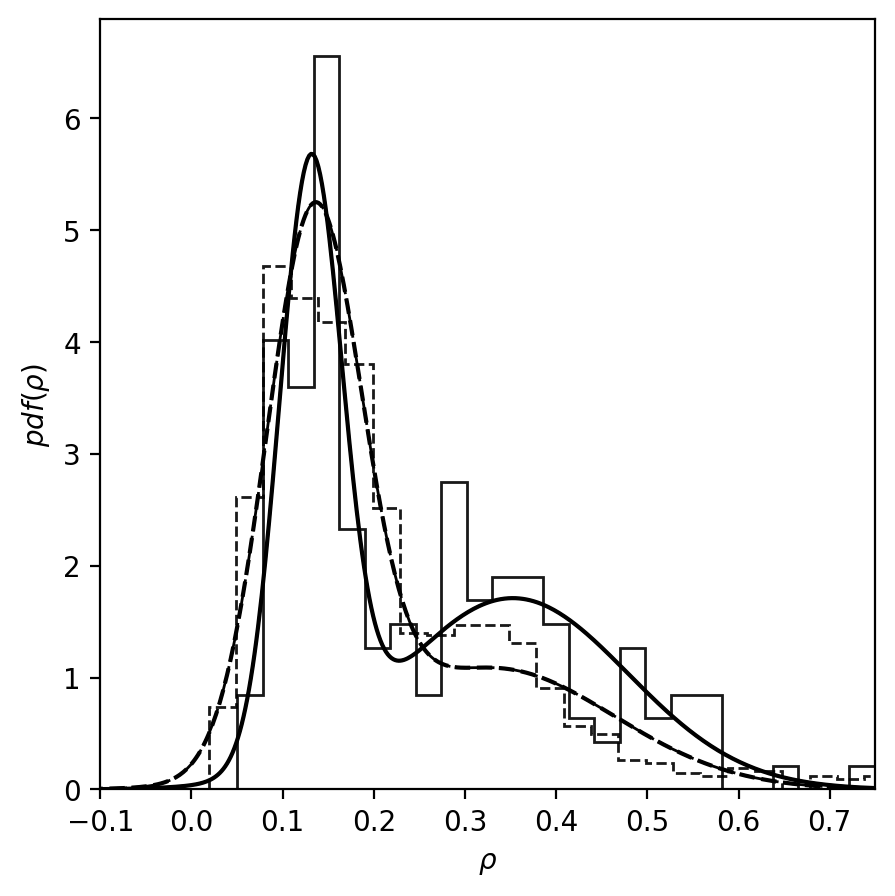

In [409]:
plt.figure(figsize=(5, 5))
gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
#dt = data2022['f_mdpi'].values.reshape(-1, 1)
# get mdpi ratios for universities in coara_list_ror_ids
dt = data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())


# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(dt, bins=25, density=True, alpha=0.9, color='black',histtype='step')
plt.plot(x, pdf, '-k', color='black', lw=1.0)
#plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k')

gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
dt = data2022['f_mdpi'].values.reshape(-1, 1)
# get mdpi ratios for universities in coara_list_ror_ids
#dt = data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(dt, bins=25, density=True, alpha=0.9, color='black',histtype='step', linestyle='--')
plt.plot(x, pdf, '-k', color='black', lw=1.0, ls='dashed')
#plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k', linestyle='--')



#plt.title('Gaussian Mixture Model')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$pdf(\rho)$')
plt.xlim(-.1, .75)
# log y scale
#plt.yscale('log')
#plt.ylim(1e-2, 20)
# plot size
plt.show()

In [410]:
# read csv from './THEUR/2023-ranking.csv' to theur
theur = pd.read_csv('./THEUR/2023_rankings.csv')

In [411]:
# find rows where 'location' is 'Slovenia'
theur[theur['location'] == 'Slovenia']

,rank_order,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,...,scores_international_outlook_rank,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited
893,8940,801–1000,University of Ljubljana,29.8–33.9,8940,21.9,961,19.5,764,47.1,...,721,Slovenia,"37,615",13.1,8%,60 : 40,University of Ljubljana,"History, Philosophy & Theology,Electrical & El...",False,False
1347,13480,1201–1500,University of Maribor,18.4–24.3,13480,17.2,1463,17.4,871,28.3,...,849,Slovenia,"12,403",14.3,10%,53 : 47,University of Maribor,"Law,History, Philosophy & Theology,Mechanical ...",False,False
1398,13990,1201–1500,University of Primorska,18.4–24.3,13990,15.8,1616,14.2,1094,16.3,...,367,Slovenia,"6,089",16.6,15%,76 : 24,University of Primorska,"Mathematics & Statistics,Other Health,Geograph...",False,False
2158,1000346,Reporter,University of Nova Gorica,NaN,1000346,NaN,0,NaN,0,NaN,...,0,Slovenia,416,3.5,54%,48 : 52,University of Nova Gorica,"Chemical Engineering,Art, Performing Arts & De...",False,False


In [412]:
theur.columns

Index(['rank_order', 'rank', 'name', 'scores_overall', 'scores_overall_rank',
       'scores_teaching', 'scores_teaching_rank', 'scores_research',
       'scores_research_rank', 'scores_citations', 'scores_citations_rank',
       'scores_industry_income', 'scores_industry_income_rank',
       'scores_international_outlook', 'scores_international_outlook_rank',
       'location', 'stats_number_students', 'stats_student_staff_ratio',
       'stats_pc_intl_students', 'stats_female_male_ratio', 'aliases',
       'subjects_offered', 'closed', 'unaccredited'],
      dtype='object')

In [413]:
# extract 'name' from theur where 'scores_overall' is not NaN to theur_list
theur_list = theur[theur['scores_overall'].notnull()]['name']

In [414]:
len(theur_list)

1799

In [415]:
count_theur_uni_ror = 0
theur_list_ror = []
theur_uni = []
for uni in theur_list:
    input_id = uni
    search_term = '"' + input_id + '"'
    params = {'query': search_term}
    response = requests.get(ROR_API_ENDPOINT + '?' + urllib.parse.urlencode(params)).json()
    if response['number_of_results'] == 0:
        ror_id = ''
    elif response['number_of_results'] >= 1:
        ror_id = response['items'][0]['id']
    #else:
    #    ror_id = ''
    #    for items in response:
    #        ror_id = ror_id + ", " + response['items'][0]['id']
    #print("Found match: " + ror_id)
    if ror_id != '':
        count_theur_uni_ror += 1
        theur_list_ror.append(ror_id)
        theur_uni.append(uni)

In [416]:
theur_list_ror_ids = [i.split('https://ror.org/')[1] for i in theur_list_ror]

In [417]:
theur_uni[321], theur_list_ror_ids[321]

('Catholic University of Portugal', '03b9snr86')

In [418]:
# extract rows from theur where 'name' is in theur_uni to theur_ror and add 'ror id' column with values from theur_list_ror_ids
theur_ror = theur[theur['name'].isin(theur_uni)]
theur_ror['ror id'] = theur_list_ror_ids

In [419]:
theur_ror

,rank_order,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,...,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited,ror id
0,10,1,University of Oxford,96.4,10,92.3,5,99.7,1,99.0,...,United Kingdom,"20,965",10.6,42%,48 : 52,University of Oxford,"Accounting & Finance,General Engineering,Commu...",False,False,052gg0110
1,20,2,Harvard University,95.2,20,94.8,1,99.0,3,99.3,...,United States,"21,887",9.6,25%,50 : 50,Harvard University,"Mathematics & Statistics,Civil Engineering,Lan...",False,False,03vek6s52
2,30,=3,University of Cambridge,94.8,30,90.9,7,99.5,2,97.0,...,United Kingdom,"20,185",11.3,39%,47 : 53,University of Cambridge,"Business & Management,General Engineering,Art,...",False,False,013meh722
3,40,=3,Stanford University,94.8,40,94.2,2,96.7,7,99.8,...,United States,"16,164",7.1,24%,46 : 54,Stanford University,"Physics & Astronomy,Computer Science,Politics ...",False,False,00f54p054
4,50,5,Massachusetts Institute of Technology,94.2,50,90.7,8,93.6,11,99.8,...,United States,"11,415",8.2,33%,40 : 60,Massachusetts Institute of Technology,"Mathematics & Statistics,Languages, Literature...",False,False,042nb2s44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,17930,1501+,West University of Timişoara,10.4–18.3,17930,18.7,1258,13.4,1158,16.8,...,Romania,"14,527",24.6,6%,66 : 34,West University of Timişoara,"Accounting & Finance,Physics & Astronomy,Busin...",False,False,0583a0t97
1793,17940,1501+,Wrocław University of Science and Technology,10.4–18.3,17940,17.9,1369,16.0,960,14.9,...,Poland,"23,657",20.3,6%,35 : 65,Wrocław University of Science and Technology,"Architecture,Chemistry,Mathematics & Statistic...",False,False,008fyn775
1794,17950,1501+,Yamaguchi University,10.4–18.3,17950,21.3,1020,12.3,1264,13.9,...,Japan,"10,724",11.1,7%,38 : 62,Yamaguchi University,"Economics & Econometrics,Mechanical & Aerospac...",False,False,03cxys317
1795,17960,1501+,Yanshan University,10.4–18.3,17960,17.2,1465,10.9,1410,18.3,...,China,"38,649",13.2,1%,39 : 61,Yanshan University,"Chemical Engineering,Geology, Environmental, E...",False,False,02txfnf15


In [98]:
# save theur_ror to theur_ror.xlsx
# theur_ror.to_excel('theur2023_ror.xlsx', index=False)

In [420]:
# merge data and theur_ror on 'ror id' column
data_theur = data.merge(theur_ror, on='ror id', how='left')

In [421]:
data_theur

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,scores_international_outlook_rank,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited
0,Harvard University,03vek6s52,United States,2023,32121,journal-article,27130,385,863,402,...,214.0,United States,"21,887",9.6,25%,50 : 50,Harvard University,"Mathematics & Statistics,Civil Engineering,Lan...",False,False
1,Shanghai Jiao Tong University,0220qvk04,China,2023,27826,journal-article,20816,290,972,355,...,842.0,China,"37,478",11.5,8%,42 : 58,Shanghai Jiao Tong University SJTU,"Medicine & Dentistry,Veterinary Science,Politi...",False,False
2,Zhejiang University,00a2xv884,China,2023,27524,journal-article,20380,296,1605,421,...,573.0,China,"46,124",12.0,16%,NaN,Zhejiang University ZJU Zhejiang University Ch...,"Architecture,Other Health,Biological Sciences,...",False,False
3,University of Toronto,03dbr7087,Canada,2023,24294,journal-article,19151,472,652,603,...,115.0,Canada,"77,468",25.8,26%,56 : 44,University of Toronto,Politics & International Studies (incl Develop...,False,False
4,Sichuan University,011ashp19,China,2023,21300,journal-article,16823,280,838,257,...,993.0,China,"49,543",15.8,6%,NaN,Sichuan University,"Mathematics & Statistics,Biological Sciences,L...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,2023,887,journal-article,752,93,79,20,...,647.0,Czech Republic,"8,763",13.8,7%,69 : 31,University of South Bohemia in České Budějovice,"General Engineering,Agriculture & Forestry,Pol...",False,False
1402,College of William and Mary,03hsf0573,United States,2023,885,journal-article,659,97,17,50,...,1078.0,United States,"8,089",10.9,8%,56 : 44,William & Mary,"Psychology,Computer Science,Sport Science,Hist...",False,False
1403,Shandong University of Traditional Chinese Med...,0523y5c19,China,2023,1570,journal-article,1179,72,42,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1404,Central South University of Forestry and Techn...,02czw2k81,China,2023,1416,journal-article,1181,63,266,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# save data_theur to data_theur.xlsx
data_theur.to_excel('all_data_with_theur2023.xlsx', index=False)


In [422]:
data_theur['rank'] = range(1, len(data_theur)+1)

In [423]:
data_theur.columns.to_list()

['uni',
 'ror id',
 'country',
 'year',
 'n_papers_all',
 'paper_type',
 'n_paper_type',
 'n_publishers',
 'n_mdpi',
 'n_taylor_francis',
 'n_springer_nature',
 'n_wiley',
 'n_sage',
 'n_elsevier',
 'n_is_retracted',
 'n_is_oa',
 'n_is_oa_gold',
 'sum',
 'f_mdpi',
 'University',
 'ROR ID',
 'Country',
 'Field',
 'Period',
 'Frac_counting',
 'impact_P',
 'collab_P',
 'oa_P',
 'TCS',
 'TNCS',
 'P_top1',
 'P_top5',
 'P_top10',
 'P_top50',
 'P_collab',
 'P_int_collab',
 'P_industry_collab',
 'P_short_dist_collab',
 'P_long_dist_collab',
 'P_OA',
 'P_gold_OA',
 'P_hybrid_OA',
 'P_bronze_OA',
 'P_green_OA',
 'P_OA_unknown',
 'MCS',
 'MCS_lb',
 'MCS_ub',
 'MNCS',
 'MNCS_lb',
 'MNCS_ub',
 'PP_top1',
 'PP_top1_lb',
 'PP_top1_ub',
 'PP_top5',
 'PP_top5_lb',
 'PP_top5_ub',
 'PP_top10',
 'PP_top10_lb',
 'PP_top10_ub',
 'PP_top50',
 'PP_top50_lb',
 'PP_top50_ub',
 'PP_collab',
 'PP_collab_lb',
 'PP_collab_ub',
 'PP_int_collab',
 'PP_int_collab_lb',
 'PP_int_collab_ub',
 'PP_industry_collab',
 'PP_i

In [424]:
data_theur[['rank_order','uni','rank']][:10]

,rank_order,uni,rank
0,20.0,Harvard University,1
1,520.0,Shanghai Jiao Tong University,2
2,670.0,Zhejiang University,3
3,180.0,University of Toronto,4
4,1970.0,Sichuan University,5
5,230.0,University of Michigan,6
6,3590.0,Central South University,7
7,160.0,Tsinghua University,8
8,2930.0,Sun Yat-sen University,9
9,150.0,Johns Hopkins University,10


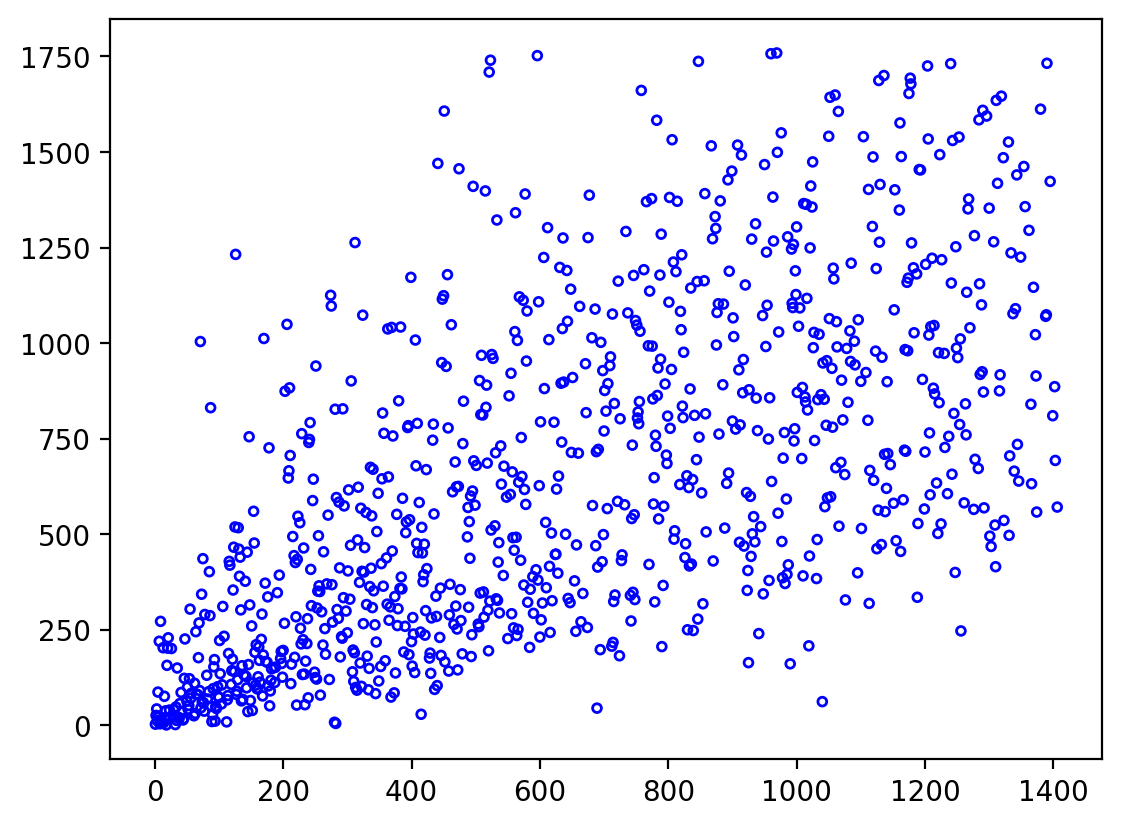

In [425]:
# plot scatter of 'scores_research' vs 'impact_P'
fig, ax = plt.subplots()
yy = data_theur['scores_research_rank']
xx = data_theur['rank']
ax.scatter(xx, yy, marker='o', s=10, facecolors='none', edgecolors='b')


In [426]:
x = np.array(data_theur['rank_order'].values)
y = np.array(data_theur['f_mdpi'].values)

# check for nan values in x and remove them and corresponding y values
nan_values = np.argwhere(np.isnan(x))
x = np.delete(x, nan_values)
y = np.delete(y, nan_values)


# find minimum x value greater than 0


# Define bins for a12 data
nbins = 500
bins = np.arange(0, np.max(x), nbins)  # 0-10, 10-20, ..., 90-100
# make log bins
#bins = np.logspace(0, np.log10(np.max(x)), nbins)


# Digitize the a12 data into bins
x_binned = np.digitize(x, bins)

# Calculate the mean of c10 in each bin
y_means = [y[x_binned == i].mean() for i in range(1, len(bins))]

# Mid-point of bins for plotting purposes
bin_midpoints = (bins[:-1] + bins[1:]) / 2

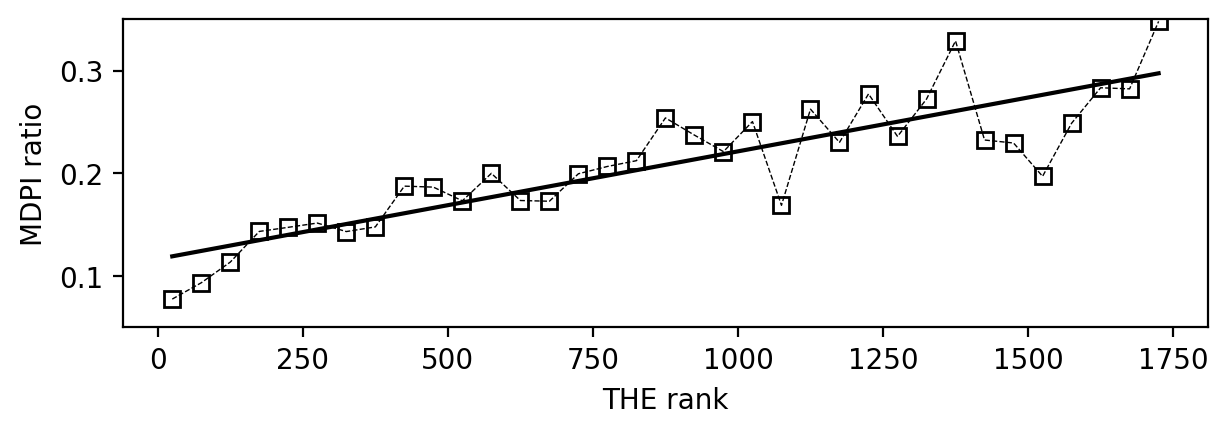

In [427]:
# Create the plot
plt.figure(figsize=(7, 2))
#plt.plot(x, y, alpha=0.2, label="Original Data", marker='.', ms=5, ls='', color='gray', mfc='none')  # Original data
plt.plot(bin_midpoints/10, y_means, marker='s',color="black", label="Binned Means", ms=6, ls='--', mfc='none',lw=0.5)  # Binned data
plt.xlabel('THE rank')
plt.ylabel('MDPI ratio')
# add linear fit line
plt.plot(np.unique(bin_midpoints/10), np.poly1d(np.polyfit(bin_midpoints/10, y_means, 1))(np.unique(bin_midpoints/10)), color='black', lw=1.5)
#plt.legend()
#plt.grid(True)
#plt.xlim(0, 1000)
plt.ylim(0.05, .35)
# log scale
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [428]:
countries = ['Denmark', 'Finland', 'Poland',
       'Greece', 'France', 'Romania', 'Germany', 'Italy', 'Czech Republic', 'Hungary', 'Spain', 'Sweden',
       'Slovakia', 'Netherlands', 'Ireland',
       'Cyprus', 'Belgium', 'Austria', 'Lithuania', 'Estonia', 'Portugal', 'Slovenia', 'Luxembourg', 'Croatia']

In [429]:
country_codes = ['DK', 'FI', 'PL', 'GR', 'FR', 'RO', 'DE', 'IT', 'CZ', 'HU', 'ES', 'SE', 'SK', 'NL', 'IE', 'CY', 'BE', 'AT', 'LT', 'EE', 'PT', 'SI', 'LU', 'HR']

In [430]:
df_indicators = pd.read_excel('../autonomy/indicators.xlsx')

In [431]:
df_indicators

,Country,PC,CC,CPI,Code,AA,SA,FA,OA,norm_Autonomy,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Sweden,0.982,0.992,0.82,SE,0.670000,0.970000,0.560000,0.590000,0.687204,...,0.765167,0.917789,0.940802,0.902056,10612.086,0.065855,64578.396333,Sweden,1.641757,1.200146
1,Poland,0.863,0.868,0.54,PL,0.680000,0.870000,0.600000,0.710000,0.720379,...,0.583164,0.795988,0.421845,0.621791,41026.067,0.274344,43268.543713,Poland,0.916413,0.004591
2,Portugal,0.906,0.848,0.61,PT,0.540000,0.620000,0.700000,0.800000,0.625592,...,0.453390,0.774925,0.750849,0.626022,10247.605,0.179513,41451.614866,Portugal,1.872676,0.780879
3,France,0.962,0.950,0.71,FR,0.420000,0.440000,0.440000,0.570000,0.251185,...,0.542736,0.767170,0.674634,0.678514,64756.584,0.075287,55492.565547,France,0.377710,1.033441
4,Germany,0.987,0.981,0.78,DE,0.876667,0.613333,0.406667,0.676667,0.584518,...,0.716512,0.854604,0.898402,0.843665,83294.633,0.082190,63149.598690,Germany,1.676135,1.898447
5,Ireland,0.980,0.959,0.77,IE,0.890000,0.580000,0.630000,0.760000,0.720379,...,0.556873,0.820507,0.854765,0.813091,5056.935,0.066482,126905.198534,Ireland,1.316353,1.354688
6,Italy,0.818,0.861,0.56,IT,0.560000,0.490000,0.700000,0.650000,0.502370,...,0.619005,0.754287,0.828770,0.703630,58870.762,0.168539,51864.977735,Italy,1.559570,1.036302
7,Latvia,0.886,0.896,0.60,LV,0.550000,0.890000,0.900000,0.690000,0.800948,...,0.760578,0.688060,0.801526,0.723622,1830.211,0.216367,39956.190477,Latvia,1.855769,1.262392
8,Netherlands,0.978,0.978,0.79,NL,0.460000,0.920000,0.660000,0.830000,0.725118,...,0.648766,0.889942,0.864005,0.819552,17618.299,0.055738,69577.404580,Netherlands,0.906708,2.218978
9,Spain,0.967,0.941,0.60,ES,0.570000,0.500000,0.550000,0.550000,0.393365,...,0.631988,0.767306,0.611952,0.788896,47519.628,0.131809,45825.195633,Spain,1.872676,1.401909


In [432]:
# replace 'Czechia' with 'Czech Republic'
df_indicators['Country'] = df_indicators['Country'].replace('Czechia', 'Czech Republic')

In [433]:
# merge df_country with df_indicators on 'Country'
df_all = pd.merge(data, df_indicators, on='Country', how='left')

In [434]:
df_all

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Harvard University,03vek6s52,United States,2023,32121,journal-article,27130,385,863,402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Shanghai Jiao Tong University,0220qvk04,China,2023,27826,journal-article,20816,290,972,355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Zhejiang University,00a2xv884,China,2023,27524,journal-article,20380,296,1605,421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,University of Toronto,03dbr7087,Canada,2023,24294,journal-article,19151,472,652,603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sichuan University,011ashp19,China,2023,21300,journal-article,16823,280,838,257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,2023,887,journal-article,752,93,79,20,...,0.661411,0.748824,0.821102,0.796422,10495.295,0.130429,49945.500104,Czechia,1.972334,0.418134
1401,College of William and Mary,03hsf0573,United States,2023,885,journal-article,659,97,17,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1402,Shandong University of Traditional Chinese Med...,0523y5c19,China,2023,1570,journal-article,1179,72,42,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403,Central South University of Forestry and Techn...,02czw2k81,China,2023,1416,journal-article,1181,63,266,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [435]:
# select rows with 'Pop1K' > 0
df = df_all[df_all['Pop1K'] > 0]

In [436]:
# add columns 'code' to df that corresponds to country codes in countries, for other countries add 'Other'
df['code'] = df['Country'].apply(lambda x: country_codes[countries.index(x)] if x in countries else 'Other')


In [437]:
df['f_mdpi'].groupby(df['Code']).mean().sort_values()

Code
NL    0.094839
SE    0.100373
DK     0.11235
FI    0.115448
LU     0.12596
IE    0.138198
FR    0.142738
BE    0.154387
DE    0.174883
AT    0.213836
EE    0.224045
CY    0.231964
CZ    0.252498
ES     0.29064
IT    0.366133
PT    0.372896
SI    0.450051
GR    0.504763
SK    0.506659
PL    0.521116
LT    0.522789
HR    0.550481
RO    0.651453
Name: f_mdpi, dtype: object

In [438]:
# add country_mean_fmdpi.iloc[4] to df as 'rho' on 'Country' column
df['rho'] = df['Country'].apply(lambda x: country_mean_fmdpi.iloc[4][x] if x in countries else 0)


In [441]:
df['f_mdpi'].groupby(df['code']).mean()

code
AT    0.213836
BE    0.154387
CY    0.231964
CZ    0.252498
DE    0.174883
DK     0.11235
EE    0.224045
ES     0.29064
FI    0.115448
FR    0.142738
GR    0.504763
HR    0.550481
IE    0.138198
IT    0.366133
LT    0.522789
LU     0.12596
NL    0.094839
PL    0.521116
PT    0.372896
RO    0.651453
SE    0.100373
SI    0.450051
SK    0.506659
Name: f_mdpi, dtype: object

In [442]:
df['rho'].groupby(df['code']).mean()

code
AT    0.196786
BE    0.147125
CY    0.238628
CZ    0.224063
DE    0.165731
DK    0.106769
EE    0.216279
ES    0.278044
FI    0.112002
FR    0.129359
GR    0.484018
HR    0.532680
IE    0.132569
IT    0.355394
LT    0.490160
LU    0.125960
NL    0.096581
PL    0.491861
PT    0.359923
RO    0.663123
SE    0.094104
SI    0.416922
SK    0.478528
Name: rho, dtype: float64

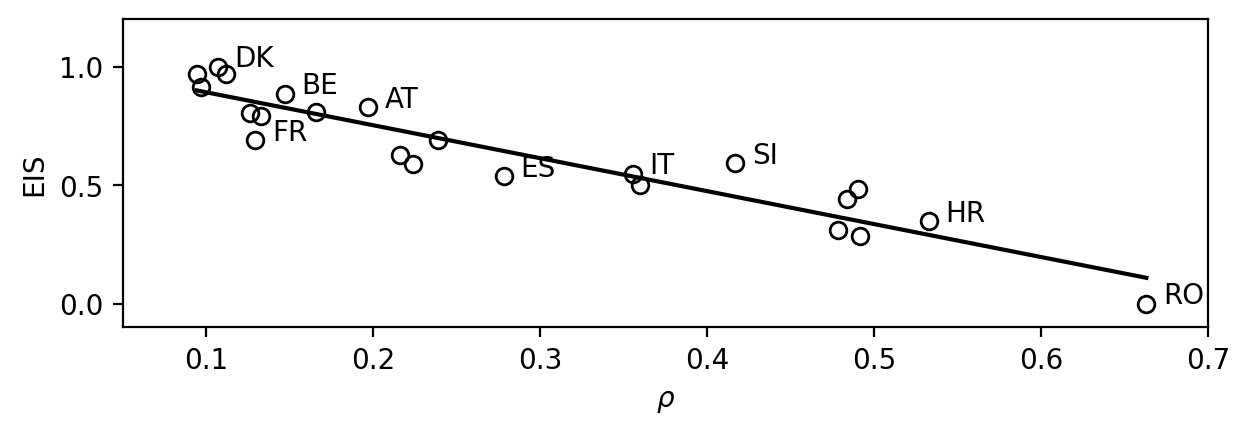

In [445]:
import numpy as np
from scipy.optimize import curve_fit
fig, ax = plt.subplots()
yy = df['norm_EIS'].groupby(df['Country']).mean().to_list()
#yy = df['MDPI 2023'].groupby(df['Country']).mean()

#xx = df['f_mdpi'].groupby(df['Country']).mean().to_list()
xx = df['rho'].groupby(df['Country']).mean().to_list()
#ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='black')
ax.plot(xx,yy,marker='.',color="black", label="Binned Means", ms=12, ls='', mfc='none',lw=0.5)

codes = df['code'].groupby(df['Country']).first()

#sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.plot(np.unique(xx), np.poly1d(np.polyfit(xx, yy, 1))(np.unique(xx)), color='black', lw=1.5)
# annotate points with 'code'
for i, txt in enumerate(codes):
    if txt in ['SI','RO','HR','IT','ES','AT','BE','DK','FR']:
        ax.annotate(txt, (xx[i]+0.01, yy[i]))



ax.set_ylim(-.1, 1.2)
ax.set_xlim(0.05, .7)
ax.set_ylabel('EIS')
ax.set_xlabel(r'$\rho$')
plt.gcf().set_size_inches(7, 2)


In [104]:
xx

Country
Austria           0.213836
Belgium           0.154387
Croatia           0.550481
Cyprus            0.231964
Czech Republic    0.252498
Denmark            0.11235
Estonia           0.224045
Finland           0.115448
France            0.142738
Germany           0.174883
Greece            0.504763
Ireland           0.138198
Italy             0.366133
Lithuania         0.522789
Luxembourg         0.12596
Netherlands       0.094839
Poland            0.521116
Portugal          0.372896
Romania           0.651453
Slovakia          0.506659
Slovenia          0.450051
Spain              0.29064
Sweden            0.100373
Name: f_mdpi, dtype: object

In [446]:
df.to_excel('all_indicators_university_level.xlsx')

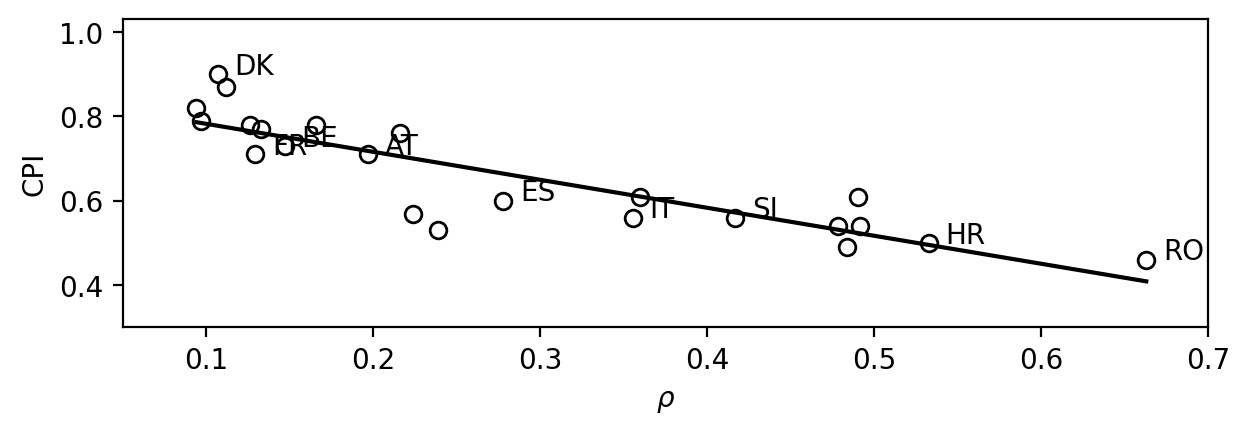

In [450]:
fig, ax = plt.subplots()
yy = df['CPI'].groupby(df['Country']).mean()
#yy = df['MDPI 2023'].groupby(df['Country']).mean()


#xx = df['f_mdpi'].groupby(df['Country']).mean().to_list()
xx = df['rho'].groupby(df['Country']).mean().to_list()

#ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='black')
ax.plot(xx,yy,marker='.',color="black", label="Binned Means", ms=12, ls='', mfc='none',lw=0.5)

codes = df['code'].groupby(df['Country']).first()

#sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.plot(np.unique(xx), np.poly1d(np.polyfit(xx, yy, 1))(np.unique(xx)), color='black', lw=1.5)
# annotate points with 'code'
for i, txt in enumerate(codes):
    if txt in ['SI','RO','HR','IT','ES','AT','BE','DK','FR']:
        ax.annotate(txt, (xx[i]+0.01, yy[i]))



ax.set_ylim(.3, 1.03)
ax.set_xlim(0.05, .7)
ax.set_ylabel('CPI')
ax.set_xlabel(r'$\rho$')
plt.gcf().set_size_inches(7, 2)

In [451]:
yy = df['norm_EIS'].groupby(df['Country']).mean().to_list()
xx = df['rho'].groupby(df['Country']).mean().to_list()

corr = stats.pearsonr(xx,yy)[0]
p_val = stats.pearsonr(xx,yy)[1]
print('Correlation:', corr)
print('P-value:', p_val)

Correlation: -0.9367187986716335
P-value: 4.8869098600751763e-11


In [452]:
yy = df['CPI'].groupby(df['Country']).mean().to_list()
xx = df['rho'].groupby(df['Country']).mean().to_list()

corr = stats.pearsonr(xx,yy)[0]
p_val = stats.pearsonr(xx,yy)[1]
print('Correlation:', corr)
print('P-value:', p_val)

Correlation: -0.8664744236079078
P-value: 9.036283976040661e-08


In [113]:
yy = df['norm_EIS'].groupby(df['Country']).mean()
xx = df['CPI'].groupby(df['Country']).mean().to_list()

corr = stats.pearsonr(xx,yy)[0]
p_val = stats.pearsonr(xx,yy)[1]
print('Correlation:', corr)
print('P-value:', p_val)

Correlation: 0.8792551366985224
P-value: 3.331412199876102e-08


In [2]:
a = -0.93
b = -0.86
a*b+(1-a*a)**0.5 * (1-b*b)**0.5, a*b-(1-a*a)**0.5 * (1-b*b)**0.5

(0.9873634292712734, 0.6122365707287267)

In [217]:
# show 'University of Ljubljana' and 'University of Maribor' rows in df
umul = df[df['University'].str.contains('Ljubljana|Maribor')][['University','impact_P','P_top10','P_top50','P_top5','P_top1','PP_top1','PP_top5','PP_top10','PP_top50']]


In [218]:
umul

,University,impact_P,P_top10,P_top50,P_top5,P_top1,PP_top1,PP_top5,PP_top10,PP_top50
356,University of Ljubljana,4910.429263,449.217045,2453.620120,223.271029,37.795978,0.007697,0.045469,0.091482,0.499675
999,University of Maribor,1611.939976,152.461861,800.270173,81.003834,15.530185,0.009634,0.050252,0.094583,0.496464


In [269]:
# compute ratio of imact_P between 'University of Ljubljana' and 'University of Maribor' add to new row 'ratio'
r = ['ratio',umul['impact_P'].iloc[0]/umul['impact_P'].iloc[1], umul['P_top10'].iloc[0]/umul['P_top10'].iloc[1], 
     umul['P_top50'].iloc[0]/umul['P_top50'].iloc[1], umul['P_top5'].iloc[0]/umul['P_top5'].iloc[1], umul['P_top1'].iloc[0]/umul['P_top1'].iloc[1],
     np.nan, np.nan, np.nan, np.nan]

r
# add r as row to umul, padding with NaN values 
umul = umul.append(pd.Series(r, index=umul.columns), ignore_index=True)


In [270]:
umul

,University,impact_P,P_top10,P_top50,P_top5,P_top1,PP_top1,PP_top5,PP_top10,PP_top50
0,University of Ljubljana,4910.429263,449.217045,2453.620120,223.271029,37.795978,0.007697,0.045469,0.091482,0.499675
1,University of Maribor,1611.939976,152.461861,800.270173,81.003834,15.530185,0.009634,0.050252,0.094583,0.496464
2,ratio,3.046285,2.946422,3.065990,2.756302,2.433711,NaN,NaN,NaN,NaN


In [191]:
# ration of 'University of Ljubljana' and 'University of Maribor' in df['impact_P']
df[df['University'].str.contains('Ljubljana')]['impact_P'].values/df[df['University'].str.contains('Maribor')]['impact_P'].values

array([3.04628543])

In [ ]:
####################